In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import scipy
from astropy import constants as const
from scipy import optimize
import scipy.integrate as integrate
from scipy.integrate import quad 
from scipy.special import *
import math

In [3]:
############################Constants##########################
G = 4.299E-9    #Gravitational constant Mpc Msol**-1 (km/s)**2

H0 = 100        #Today's Hubble constant km/s/Mpc

Myear = 1E6

a_year_in_seconds = math.pi * 1E7 #units of seconds

speed_of_light = 3E10 #cm/s

Msolar = 1.99E33 #units of grams

In [4]:
#############Bolshoi-Planck Cosmological paramters##############
Om_mat_cero = 0.307

Om_lambda_cero = 0.693

Om_baryons = 0.048

sigma8  =  0.829

h  =  0.678

In [5]:
######################################Cosmology#######################################
def Om_m(Om_mat_cero,Om_lambda_cero,z):
    #Omega Matter as a function of redshift
    return Om_mat_cero * ( 1. + z )**3/( Om_lambda_cero + Om_mat_cero * ( 1. + z )**3 )

def Om_l(Om_mat_cero,Om_lambda_cero,z):        #Omega lambda
    #Omega Lambda as a function of redshift
    return Om_lambda_cero / ( Om_lambda_cero + Om_mat_cero * ( 1. + z )**3 )

def H(Om_mat_cero,Om_lambda_cero,z):
    #Hubble parameters as a function of redshift
    #output km/s/Mpc
    return H0 * np.sqrt( Om_lambda_cero + Om_mat_cero * ( 1. + z )**3 )

def rho_crit(Om_mat_cero,Om_lambda_cero,z):
    #Critical density as a function of redshift
    #output M_sun / Mpc**3
    return 3 * H(Om_mat_cero,Om_lambda_cero,z)**2 / 8 / math.pi /G

def rho_m(Om_mat_cero,Om_lambda_cero,z):
    return Om_m(Om_mat_cero,Om_lambda_cero,z)*rho_crit(Om_mat_cero,Om_lambda_cero,z)

def AgeUniverse(Om_mat_cero, Om_lambda_cero, h, z):
    #output units of years
    #Hubble constant is H0 * h
    
    T_Hubble = 1.02E-12
    
    one_plus_z = 1. + z
    
    Olz = Om_lambda_cero *one_plus_z**(-3)
    
    T1 = 2. / np.sqrt( Om_lambda_cero ) / 3. / H(Om_mat_cero,Om_lambda_cero,0.) / T_Hubble / h
    
    T2 = np.sqrt(Olz)
    
    T3 = np.sqrt(Olz +  Om_mat_cero)
    
    TH = T1 * np.log( ( T2 + T3 ) / np.sqrt(Om_mat_cero) )
    
    return TH

def DZ(z,DT): #calculates the redshift z+dz given an interval of time DT and z. DT input is in Myrs
    
    def Delta_T(z_dz,DT,z):
        
        DT_age = AgeUniverse(Om_mat_cero,Om_lambda_cero,h,z) - AgeUniverse(Om_mat_cero,Om_lambda_cero,h,z_dz)
        
        return DT - DT_age / 1E6
    
    z_f = optimize.bisect(Delta_T, 0, 1000, args=(DT,z))
    
    return z_f

In [6]:
######################Stellar-to-Halo Mass Relations###########################
def SHMR(z, Mvirz):
    #Rodriguez-Puebla 2017
    #star to halo mass relation
    #Section 3.2 Parametrization of the SHMR (stellar to mass relation halo) Rodriguez-Puebla 2017
    #input: redshift, intial virial mass (halo)
    #units: Mvirz in solar mass
    #output; stellar mass for the given halo mass
    #units of solar mass
    
    
    M = Mvirz

    def P(x, y, z):
        return y*z - x*z/(1+z)

    def Q(z):
        return np.exp(-4/(1.+z)**2)

    def g(x, a, g, d):
        return (-np.log10(10**(-a*x)+1.) +
                d*(np.log10(1.+np.exp(x)))**g/(1.+np.exp(10**(-x))))

    al = (1.975, 0.714, 0.042)
    de = (3.390, -0.472, -0.931)
    ga = (0.498, -0.157)
    ep = (-1.758, 0.110, -0.061, -0.023)
    M0 = (11.548, -1.297, -0.026)

    #Section 5 Rodriguez-Puebla 2017
    #Constrains for the model. Madau & Dickinson (2014)
    
    alpha = al[0] + P(al[1], al[2], z) * Q(z)
    delta = de[0] + P(de[1], de[2], z) * Q(z)
    gamma = ga[0] + P(ga[1], 0, z) * Q(z)

    eps = 10**(ep[0] + P(ep[1], ep[2], z)*Q(z) + P(ep[3], 0, z))
    M1 = 10**(M0[0] + P(M0[1], M0[2], z)*Q(z))

    x = np.log10(M/M1)
    g1 = g(x, alpha, gamma, delta)
    g0 = g(0, alpha, gamma, delta)

    Ms = 10**(np.log10(eps*M1) + g1 - g0)
    
    return Ms

In [7]:
########################Halo Mass Growth###############################

def halo_mass_assembly(Mvir0, z0, z):
    #Halo mass growth at any z fo a progenitor mass Mvir0 at z0 
    #Improve fit to ecs 18-22 from RP16 Bolshoi-Planck paper
    #Halo-mass assembly graph
    #inputs: Initial virial mass, redshift(0) initial time, redshift array
    #units: solar mass
    #output: halo mass growth 
    #units: solar mass
    
    def a0M0(log10Mvir0):
        
        X = 29.6272 - log10Mvir0
        
        return 1.37132 - np.log10( 10**( 0.077364 * X ) + 1. )
    
    def gM0( log10Mvir0, a_scale):
        
        return 1. + np.exp( -3.79656 * ( a_scale - a0M0(log10Mvir0) ) )
    
    def M13(z):
        
        log10Mh013 = 13.
        
        alpha = 2.77292
        
        beta = -5.66267
        
        gamm = -0.469065
        
        return log10Mh013 + alpha * np.log10( 1. + z ) + beta * np.log10( 1. + 0.5 * z ) + gamm * z * np.log10( np.exp(1.) )
    
    def fM0z( log10Mvir0,z):
        
        a_scale = 1. / ( 1. + z )
        
        return ( log10Mvir0 - M13(0.) ) * gM0( log10Mvir0, 1. ) / gM0( log10Mvir0, a_scale)
    
    log10Mvir0 = np.log10(Mvir0) + np.log10( h )
    
    log10Mvir_13 = M13(z-z0) + fM0z(log10Mvir0, z - z0 ) - np.log10( h )
    
    return 10**log10Mvir_13

In [8]:
########################Galaxy Mass Growth############################

# The rate at which dark matter haloes grow will determine the rate at which the cosmological baryonic
# inflow material reaches the ISM of a galaxy. Eventually, when necessary conditions are satisfied, some of 
# this cosmological baryonic material will be transformed into stars. 
# As described in Section 2.2, we use the growth of dark matter haloes to predict the SFHs of galaxies
# without modelling how the cold gas in the galaxy is converted into stars.

def galaxy_mass_assembly(Mvir0, z0, z):
    #stellar mass growth at any z for a progenitor halo mass Mvir0 @ z0 
    #Halo growth and stellar relationship, galaxy mass evolution
    #inputs: Initial virial mass, redshift(0), redshift array
    #units solar mass
    #output: stellar mass growth within halo
    #units: solar mass
    
    Mvirz = halo_mass_assembly(Mvir0, z0, z)
    
    Ms_z = SHMR(z, Mvirz)
    
    return Ms_z

def f_int(Mvir, z):
    #Instantaneous fraction of stellar mass from Mergers
    #all type of mergers Ec; 34-36 RP17
    #No units, this is just a fraction
    
    log10Mvir = np.log10(Mvir)
    
    a_scale = 1. / ( 1. + z )
    
    beta_merger = 0.760 + np.log10( 1. + z )
    
    logM_merge = 12.728 - 2.790 * ( a_scale - 1. )
    
    frac_merge = 10**( beta_merger * ( log10Mvir - logM_merge ) )
    
    frac_merge = 1. / ( frac_merge + 1. )
    
    return frac_merge

In [9]:
########################Star Formation histories###########################

def dMsdt(Mvir0, z0, z):
    #Stellar mass formation rate
    #Derivative of Galaxy mass assembly with respect to Age of Universe
    #input initial virial mass in solar mass
    #output units of solar masses per year
    #if you are using a diff cosmology be sure to change the constants below
    
    time_burst = 100  #100 Myrs
    
    zi = z
    
    zf = DZ(z,time_burst)

    mi = galaxy_mass_assembly(Mvir0, z0, zi)
    
    mf = galaxy_mass_assembly(Mvir0, z0, zf)
    
    delm = mi - mf
    
    delT = time_burst * Myear;
    
    return delm / delT

def R_stell_frac(Time):
    #Given by Aldo
    #fraction Stellar mass loss that comes back to ISM in form of gas
    
    C0 = 0.05
    
    lam = 1.46E5 #what is this number and what are the units
    
    return C0*np.log(Time/lam + 1.) #untiless, just a fraction


def SFR(Mvir0, z0, z):
    #Stellar mass formation rate corrected, stellar mass loss fraction included
    #Given by Aldo
    #input initial virial mass in solar mass
    #output units of solar masses per year
    #In situ star formation. F_int takes into account the fraction of mass by mergers, see Section 2.2 RP17, Ecs 12-13.
    
    Mvir = halo_mass_assembly(Mvir0, z0, z)
    
    TU = AgeUniverse(Om_mat_cero, Om_lambda_cero, h, z)
    #gotta change the values if I change the cosmology
    
    DMsDt = dMsdt(Mvir0, z0, z)
    
    sfr_gal = DMsDt * f_int(Mvir,z) / (1. - R_stell_frac(TU)) #Ec 14 RP17.
    
    if DMsDt<=0:
        sfr_gal=0;
    
    return sfr_gal

In [10]:
########################Dark Matter halo dynamics & strcuture###########################

def Vmax(Mvir,z):
    #max value in DMhalo rotation curve
    #First step to introduce SN feedback
    #Rodriguez-Puebla 2016
    #Equations 4-7
    #input initial virial mass in solar mass
    #units out: km/s
    
    def alpha(z):
        
        aexp = 1. / (1+z)
        
        return 0.346 - 0.059*aexp + 0.025*aexp**2
    
    def beta(z):
        aexp = 1. / (1+z)
        return 10**(2.209 + 0.060*aexp - 0.021*aexp**2)
    
    def E(z):
        #gotta change the values if I change the cosmology
        return np.sqrt(Om_lambda_cero + Om_mat_cero*(1 + z)**3)
    
    def V(Mvir, z):
        
        M12 = Mvir / 1E12
        
        return beta(z) * ( M12 * E(z) )**alpha(z)
    
    return V(Mvir,z)


def Vmax_assembly(Mvir0, z0, z):
    #Peak of the Halo rotation curve with halo mass growth
    #units input: solar mass
    #units outut: km/s

    Mvirz = halo_mass_assembly(Mvir0, z0, z)
    
    vmax_z = Vmax(Mvirz, z)
    
    return vmax_z

def del_h(z):
    
    #def DELTA(z):
        
    x= Om_mat_cero * (1+z)**3 / (Om_mat_cero * (1+z)** 3+ Om_lambda_cero)-1
        
    return (18 * np.pi * np.pi + 82 * x - 39 * x * x) / (1+x)
    
def rho_crit(Om_mat_cero,Om_lambda_cero,z):
    #Critical density as a function of redshift to denote a flat universe
    #if this density is bigger, the universe has a positve curvature and recolapses
    #if this density is negatiev then the univerese is opened and it expands for ever
    #output M_sun / Mpc**3
    
    return 3 * H(Om_mat_cero,Om_lambda_cero,z)**2 / 8 / np.pi /G

def r_vir(Mvir, Om_mat_cero, Om_lambda_cero, z):
    #limiting radius/ virial radius: where the mean matter density is in the halo
    #input M_sun, and takes Mpc**3
    #output Kpc
    
    rho = rho_crit(Om_mat_cero,Om_lambda_cero,z) * Om_m(Om_mat_cero,Om_lambda_cero,z)
    
    d_h = del_h(z)
    
    rh = Mvir / ( 4/3 * np.pi * rho * del_h(z) )

    rh = rh **0.3333
    
    rh = rh * 1000

    return rh #* 1000 / h

def c_vir(Mvir, z, h):
    #concentration of virial mass in dark matter halo
    #no units
    
    mm=0.097
    
    ww=0.029
    
    gamma1=16.885
    
    alp= -110.001
    
    bet=2469.720
    
    log10Mvir = np.log10(Mvir) + np.log10( h )

    a = ww * z - mm
    
    b = alp / ( z + gamma1 ) + bet / ( z + gamma1 )**2. 
    
    C = b + a * np.log10(Mvir)
    
    return 10**C

def M_h_profile(Mvir, r,  Om_mat_cero, Om_lambda_cero, z, h): 
    #Describes the halo mass as a function of radius
    #Units: Msun 
    
    def g(cvir,x):
        
        num = np.log(1+cvir*x) -  cvir*x / (1+cvir*x)
        
        den = np.log(1+cvir) -  cvir / (1+cvir)
        
        ratio = num/den
        
        return ratio
    
    rv = r_vir(Mvir, Om_mat_cero, Om_lambda_cero, z)
    
    x = r/rv
    
    cvir = c_vir(Mvir, z, h) 
    
    mr = Mvir * g(cvir,x) 
    
    return mr

In [11]:
##############################Galaxy distribution & structure #####################################################

def fQ(Ms,z):
    #Fraction of quenched galaxies as a function of stellar mass
    #Equation 44 from Rodriguez-Puebla et al. 2017.
    #input: Solar Mass
    #output: uniteless

    ratio = np.log10(Ms) - (10.2 + 0.6 * z)
    
    ratio = 10**(-1.3 * ratio)
    
    ratio = 1. + ratio
    
    return 1. / ratio


def fSF(Ms,z):
    #Fraction of star-forming galaxies as a function of stellar mass
    #FQ+FSF = 1.

    return 1. - fQ(Ms,z)


def Reff(a, b, g, M0, Ms):
    #Efficetive radius of a galaxy @ which  half of the total light of the system is emitted.
    #Mosleh 2013  eq:4
    #input Ms, M0 units
    #output: radius units: kpc
    
    
    return g*(Ms**a)*(1+(Ms/M0))**(b-a)

def Reff_sf(Ms, z):
    #effective raduis for star forming galaxies 
    #RP 2017 EQ: 63
    #input redshift and stellar mas. units: solar mass
    #output: radius. Units: kpc
    
    a = 0.109
    
    b = 0.263
    
    g = 10**(-0.743)
    
    M0 = 10**10.204
    
    Reff_sf = Reff(a, b, g, M0, Ms)

    H_z = H(Om_mat_cero,Om_lambda_cero,z)
    
    H_0 = H(Om_mat_cero,Om_lambda_cero,0)
    
    return Reff_sf*(H_z/H_0)**(-0.5)

def Reff_Q(Ms, z):
    #effective radius for quenched galaxies
    #RP 2017 EQ: 63
    #input redshift and stellar mas. units: solar mass
    #output: radius. Units: kpc
    
    a = 0.014
    
    b = 0.912
    
    g = 10**(-0.058)
    
    M0 = 10**10.555
    
    Reff_sf = Reff(a, b, g, M0, Ms)

    H_z = H(Om_mat_cero,Om_lambda_cero,z)
    
    H_0 = H(Om_mat_cero,Om_lambda_cero,0)
    
    return Reff_sf*(H_z/H_0)**(-0.85)


def Sersic_sf_mass_density(Ms, z, r):
    #The Sersic function describes the surface brightness of a galxy @ a radius r
    #n=1 sersic index for quenched galaxies 
    #RP 2017 EQ: 60
    #input: stellar mass (solar mass), redshift, radius(kpc)
    #output: mass density
    #units Msun/kpc^2
    
    n= 1
    
    bn = 1.67835
    
    R_eff = Reff_sf(Ms, z)
    
    ratio= r / R_eff
    
    exponent = -bn * ( (ratio) - 1)
    
    Rd = R_eff * R_eff * np.exp(bn) / bn**2.0 
    
    S0 = Ms/2/np.pi/Rd #Sigma 0 is the surface mass density at the effective radius
    
    return S0 * np.exp(exponent)


def Sersic_q_mass_density(Ms, z, r):
    #The Sersic function describes the surface brightness of a galxy @ a radius r
    #n=4 sersic index for quenched galaxies 
    #RP 2017 EQ: 60
    #input: stellar mass (solar mass), redshift, radius(kpc)
    #output: mass density 
    #units Msun/kpc^2
    
    n= 4
    
    bn = 7.669
    
    R_eff = Reff_Q(Ms, z)
    
    ratio= (r / R_eff)**0.25
    
    exponent = -bn * ( (ratio) - 1)
    
    Rsph = 20160 * R_eff * R_eff * np.exp(bn) / bn**8.0
    
    S0 = Ms/2/np.pi/Rsph
    
    S0 = S0  * np.exp(exponent)
    
    
    return S0

def mass_density_avg(Ms, z, r):
    #average radial distribution of galaxies with total stellar mass M*
    #units Msun/kpc^2
    
    mass_density_all = fSF(Ms,z)*Sersic_sf_mass_density(Ms, z, r) + (1 - fSF(Ms,z))*Sersic_q_mass_density(Ms, z, r)
    
    return mass_density_all

def mass_profile(r, Ms, z):
    #input: stellar mass (solar mass), redshift, radius(kpc)
    #units: Msun

    Mtotr = fSF(Ms,z) * mass_profile_disk(Ms,z,r) + (1 - fSF(Ms,z))* mass_profile_sph(Ms,z,r) if r >0 else 0.

    return  Mtotr


def avg_rad_eff(Ms, z):
    #input: stellar mass (solar mass)
    #units: kpc

    def f(r, Ms, z):
        
        return 0.5*Ms - mass_profile(r, Ms, z)
    
    r_m2 = optimize.fsolve(f, 1, args=(Ms, z),xtol=1E-5)
    
    return r_m2

def central_disk_dens(Md, z):
    #Epsilon naught from from disk density dristributi. Need it to calculate 
    #circular velocity of thin exponential disk.
    #input:Disk mass and effective radius (Msun, kpc)?
    #output untis: Msun/kpc^2?
    
    bn = 1.67835
    
    Rd = Reff_sf(Md, z)/bn
    
    return Md / (2 * np.pi * Rd**2)

def circ_vel_disk(Md, r, z):
    #rotation curves of disk galaxies can be used to infer the darm matter 
    #distribution if the  dark halo
    
    eps_n = central_disk_dens(Md, z) #[Msol/kcp^2]
    
    bn = 1.67835
    
    Rd = Reff_sf(Md, z)/bn
    
    y = r/(2*Rd)
    
    ##Bessel functions
    I0 = scipy.special.i0(y)
    K0 = scipy.special.k0(y)
    I1 = scipy.special.i1(y)
    K1 = scipy.special.k1(y)
    
    c = 4 * np.pi * G * 1000. # Here G * 1000 = [kpc * Msol^-1 * (km/s)^2]

    vrot2 = c * eps_n * Rd * (y**2) * (I0*K0 - I1*K1)

    return np.sqrt(vrot2)

def mass_profile_disk(Md, z, r):
    #mass profile disk portion of galaxy
    #input: stellar mass (solar mass), redshift, radius(kpc)
    #units: Msun

    bn = 1.67835
    
    Rd = Reff_sf(Md, z)/bn

    Mtotr = Md * ( 1. - ( 1. + ( r / Rd ) ) * np.exp( -r / Rd ) ) if Rd > 0 else 0.

    return  Mtotr


def mass_profile_sph(Msph, z, r):
    #mass profile bulge portion of galaxy
    #input: stellar mass (solar mass), redshift, radius(kpc)
    #units: Msun

    def Pn4(bn,Reff,r):
    
        x = r / Reff
    
        S14 = x**0.25
    
        S34 = x**0.75
    
        S12 = x**0.50
    
        fx1 = -4 * Reff * np.exp( - bn * ( S14 - 1.) ) / bn**8.
    
        fx2 = 840 * Reff * (( bn**3) * S34 + 3. * (bn**2) * S12 + 6. * bn * S14 + 6.)
    
        fx3 =  bn**4. * r * ( ( bn**3) * S34 + 7. * (bn**2) * S12 + 42. * bn * S14 + 210.)
    
        return fx1 * ( fx2 + fx3 )

    n= 4
    
    bn = 7.669
    
    Reff = Reff_Q(Msph, z)

    gamser = 1. - Pn4(bn,Reff,r)/Pn4(bn,Reff,0.)

    Mtotr = gamser * Msph if Reff > 0 else 0.
    
    return Mtotr


def circ_vel_bulge(Ms, r, z):
    # Here G * 1000 = [kpc * Msol^-1 * (km/s)^2], r is kpc, final units are then (km/s)^2
    
    vc = G * mass_profile_sph(Ms, z, r)  * 1000. / r
    
    return np.sqrt(vc)

def circ_vel_halo(Mvir, r,  Om_mat_cero, Om_lambda_cero, z, h):

    vc = G * M_h_profile(Mvir, r,  Om_mat_cero, Om_lambda_cero, z, h)  * 1000. / r # Here G * 1000 =  [kpc * Msol^-1 * (km/s)^2], r is kpc, final units are then (km/s)^2
    return np.sqrt(vc)

def circ_vel_total(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, h):

    Msph = (1. - fSF(Ms,z)) * Ms   #The fraction of mass on the spheroid component of the galaxy

    Md = fSF(Ms,z) * Ms   #The fraction of mass on the disk component of the galaxy

    vd = circ_vel_disk(Md,r,z)

    vsph = circ_vel_bulge(Msph,r,z)

    vh = circ_vel_halo(Mvir,r,Om_mat_cero, Om_lambda_cero, z, h)

    vtot2 = vd * vd + vsph * vsph + vh * vh #Total circular velocity. Velocity is a vector this its magnitude

    return np.sqrt(vtot2)

In [12]:
######################### SNE & AGN feedback############################
def KE(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, h):
    
    Mhalo = (1-Ms/Mvir) * Mvir
    
    Mreff = (M_h_profile(Mhalo, r,  Om_mat_cero, Om_lambda_cero, z, h) + mass_profile(r, Ms, z)) * Msolar #change to grams
    
    Vrot = circ_vel_total(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, h)*100000 #change to cm/s
    
    return .5 * Mreff * Vrot**2


def SNE_feedback(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, z0, h):
    #Given by Aldo
    #input unitls of solar mass
    #unitless, just a fraction
    
    EK = KE(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, h)
    #kitenic energy of the halo
    
    ESN = 10**51
    #units of ergs
    
    epsilon_SN = 0.05
    #fraction of the SN energy explosion transformed into kinetic Energy, Page 403 Mo d et al. Book
    
    N_SN = 8.0E-3
    #one supernova per 125 Msol: units solar mass^{-1}
    
    #    E_SFR = SFR(Mvir0, z0, redshift) * ESN * epsilon_SN * N_SN
    E_SFR = SFR(Mvir, z0, z) * 100 *ESN * epsilon_SN * N_SN  * Myear
    #Msun/year * ergs * unitless * 1/Msun * 100 Myear * 10^6 years
    #output units of ergs
    #mass formed in stars times the mass that became supernovae times the eficency of the explosion to go through the ISM
    
    
    return E_SFR / EK



def Mbh_Ms_SF(Ms,z):
    #Blackhole mass - stellar mass relation for star-forming galaxies
    #Reines & Volonteri 2015.
    #input: Solar Mass
    #output: Solar Mass
    
    Mbh = 7.45 + 1.05 * ( np.log10(Ms) - 11.)
    
    Mbh = 10**Mbh

    return Mbh
###why there's input for z if we're not using it 


def Mbh_Ms_Q(Ms,z):
    #Blackhole mass - stellar mass relation for quenched galaxies
    #Reines & Volonteri 2015.
    #input: Solar Mass
    #output: Solar Mass

    Mbh = 8.95 + 1.40 *  ( np.log10(Ms) - 11.)

    Mbh = 10**Mbh
    
    return Mbh

#find equation number and look for z


def average_MBH_Ms_relation(Mvir0, z0, z):
    #Average Blackhole mass - stellar mass relation. Takes into account SFing and quenched galaxies.
    #We are assuming lognormal distributions for both SFing and quenched galaxies.
    #units of solar mass both input and output
    
    Ms = galaxy_mass_assembly(Mvir0, z0, z)

    Mbh = fQ(Ms,z) * np.log10(Mbh_Ms_Q(Ms,z))  + fSF(Ms,z) *  np.log10(Mbh_Ms_SF(Ms,z))
    
    Mbh = 10**Mbh

    return Mbh



def dMBH_dt(Mvir0, z0, z):
    #Black hole mass growth rate from the average Blackhole mass - stellar mass relation
    #output units of solar mass per year
    
    time_burst = 100  #100 Myrs
    
    zi = z
    
    zf = DZ(z,time_burst)

    mi = average_MBH_Ms_relation(Mvir0, z0, zi)
    
    mf = average_MBH_Ms_relation(Mvir0, z0, zf)
    
    delm = mi - mf

    delT = time_burst * Myear;
    
    return delm / delT


def Lum_quasar(Mvir0, z0, z):
    #Bolometric luminosoty of quasar given my SMBH accreting gas
    #Mbh/dt is in units are in solar mass per yr, and I need it g per sec
    
    
    dMdt = dMBH_dt(Mvir0, z0, z) * Msolar / a_year_in_seconds
    
    eps_acc = 0.1
    
    Lqso = ((eps_acc * speed_of_light**2) / (1- eps_acc)) * dMdt
    
    #return Luminosity in units of erg*s^-1
    #erg = g*cm^2/s^2
    
    return Lqso

def Lum_eddigton(Mvir0, z0, z):
    
    #units of ergs
    
    g = const.G.value * (100**3) /1000 #m^3/kgs^2 to cm^3/gs^2
    
    mp = const.m_p.value * 1000 #kg to gram
    c = const.c.value *100 #m to cm
    
    solar = 1.99E33 #units of grams
    
    sig = const.sigma_T.value *100**2 #m^2 to cm^2
    
    num = 4*np.pi* g * mp * c
    
    den = sig
    
    Mbh = average_MBH_Ms_relation(Mvir0, z0, z) #* solar #I commented this multiplication
    
    #check that num/den = 1.26E38
    #originally you code retunr: (num*Mbh) / den
    #but I simplified to 1.26E38 * Mbh
 
    return 1.26E38 * Mbh

def AGN_feedback(Mvir0, Ms, r,  Om_mat_cero, Om_lambda_cero, z, z0, h):
    #feedback due to AGN
    #Calculates energy from quasar and then it's divived by the kinetic
    #of the halo
    #takes in units of ergs
    
    eta = 1. #(croton+)
    
    Mvir = halo_mass_assembly(Mvir0,z0,z)
    
    EK = KE(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, h)
    #ergs
    
    E_qso = eta * Lum_quasar(Mvir0, z0, z) * 100 * Myear * a_year_in_seconds
    #Lum_quasar = erg/s
    #Lum_quasar * 100 * Myear  * a_year_in_seconds = Energy release in a period of 100 Myears.
    
    return E_qso / EK

def AGN_feedback_eddigton(Mvir0, Ms, r,  Om_mat_cero, Om_lambda_cero, z, z0, h):
    #feedback due to Eddigton Luminosity
    #Calculates energy from quasar and then it's divived by the kinetic
    #of the halo
    #takes in units of ergs
    
    eta = 1. #(croton+)
    
    Mvir = halo_mass_assembly(Mvir0,z0,z)
    
    EK = KE(Mvir, Ms, r,  Om_mat_cero, Om_lambda_cero, z, h)
    #ergs
    
    E_qso = eta * Lum_eddigton(Mvir0, z0, z) * 100 * Myear * a_year_in_seconds
    #Lum_quasar = erg/s
    #Lum_quasar * 100 * Myear  * a_year_in_seconds = Energy release in a period of 100 Myears.
    
    return E_qso / EK

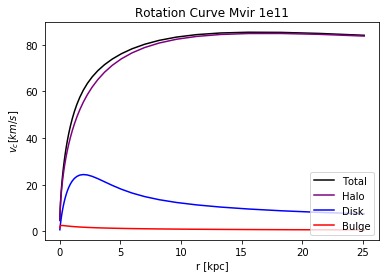

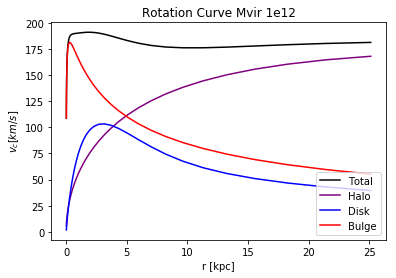

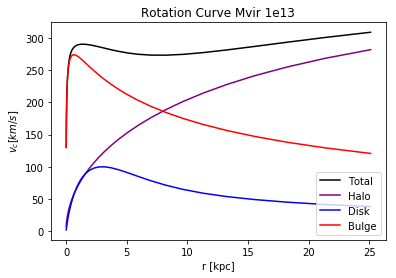

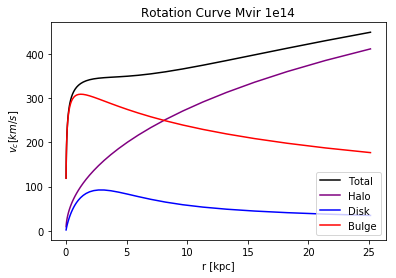

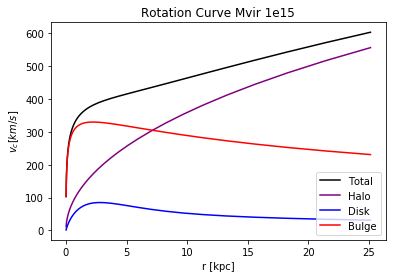

In [13]:
################################Figures#############################################


###################Circular velocity################################

z= 0.
Mvir = (1e11,1e12,1e13,1e14,1e15)
Ms = SHMR(z,Mvir[0])

Md = fSF(Ms,z) * Ms

Msph = (1. - fSF(Ms,z)) * Ms

vel_tot = []

vel_d = []

vel_sph = []

vel_halo = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot.append(circ_vel_total(Mvir[0], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo.append(circ_vel_halo(Mvir[0], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d.append(circ_vel_disk(Md, r, z))
    vel_sph.append(circ_vel_bulge(Msph, r, z))

plt.title('Rotation Curve Mvir 1e11')
plt.plot(radius, vel_tot, '-k', color='black', label='Total')
plt.plot(radius, vel_halo, '-k', color='purple', label='Halo')
plt.plot(radius, vel_d, '-k', color='blue', label='Disk')
plt.plot(radius, vel_sph, '-k', color='red', label='Bulge')
plt.xlabel('r [kpc]')
plt.ylabel('$v_c[km/s]$')
plt.legend(loc='lower right')
plt.show()

Ms = SHMR(z,Mvir[1])

Md = fSF(Ms,z) * Ms

Msph = (1. - fSF(Ms,z)) * Ms


vel_tot1 = []

vel_d1 = []

vel_sph1 = []

vel_halo1 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot1.append(circ_vel_total(Mvir[1], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo1.append(circ_vel_halo(Mvir[1], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d1.append(circ_vel_disk(Md, r, z))
    vel_sph1.append(circ_vel_bulge(Msph, r, z))

plt.title('Rotation Curve Mvir 1e12')
plt.plot(radius, vel_tot1, '-k', color='black', label='Total')
plt.plot(radius, vel_halo1, '-k', color='purple', label='Halo')
plt.plot(radius, vel_d1, '-k', color='blue', label='Disk')
plt.plot(radius, vel_sph1, '-k', color='red', label='Bulge')
plt.xlabel('r [kpc]')
plt.ylabel('$v_c[km/s]$')
plt.legend(loc='lower right')
plt.show()

Ms = SHMR(z,Mvir[2])

Md = fSF(Ms,z) * Ms

Msph = (1. - fSF(Ms,z)) * Ms


vel_tot2 = []

vel_d2 = []

vel_sph2 = []

vel_halo2 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot2.append(circ_vel_total(Mvir[2], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo2.append(circ_vel_halo(Mvir[2], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d2.append(circ_vel_disk(Md, r, z))
    vel_sph2.append(circ_vel_bulge(Msph, r, z))

plt.title('Rotation Curve Mvir 1e13')
plt.plot(radius, vel_tot2, '-k', color='black', label='Total')
plt.plot(radius, vel_halo2, '-k', color='purple', label='Halo')
plt.plot(radius, vel_d2, '-k', color='blue', label='Disk')
plt.plot(radius, vel_sph2, '-k', color='red', label='Bulge')
plt.xlabel('r [kpc]')
plt.ylabel('$v_c[km/s]$')
plt.legend(loc='lower right')
plt.show()

Ms = SHMR(z,Mvir[3])

Md = fSF(Ms,z) * Ms

Msph = (1. - fSF(Ms,z)) * Ms


vel_tot3 = []

vel_d3 = []

vel_sph3 = []

vel_halo3 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot3.append(circ_vel_total(Mvir[3], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo3.append(circ_vel_halo(Mvir[3], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d3.append(circ_vel_disk(Md, r, z))
    vel_sph3.append(circ_vel_bulge(Msph, r, z))

plt.title('Rotation Curve Mvir 1e14')
plt.plot(radius, vel_tot3, '-k', color='black', label='Total')
plt.plot(radius, vel_halo3, '-k', color='purple', label='Halo')
plt.plot(radius, vel_d3, '-k', color='blue', label='Disk')
plt.plot(radius, vel_sph3, '-k', color='red', label='Bulge')
plt.xlabel('r [kpc]')
plt.ylabel('$v_c[km/s]$')
plt.legend(loc='lower right')
plt.show()

Ms = SHMR(z,Mvir[4])

Md = fSF(Ms,z) * Ms

Msph = (1. - fSF(Ms,z)) * Ms

vel_tot4 = []

vel_d4 = []

vel_sph4 = []

vel_halo4 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot4.append(circ_vel_total(Mvir[4], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo4.append(circ_vel_halo(Mvir[4], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d4.append(circ_vel_disk(Md, r, z))
    vel_sph4.append(circ_vel_bulge(Msph, r, z))

plt.title('Rotation Curve Mvir 1e15')
plt.plot(radius, vel_tot4, '-k', color='black', label='Total')
plt.plot(radius, vel_halo4, '-k', color='purple', label='Halo')
plt.plot(radius, vel_d4, '-k', color='blue', label='Disk')
plt.plot(radius, vel_sph4, '-k', color='red', label='Bulge')
plt.xlabel('r [kpc]')
plt.ylabel('$v_c[km/s]$')
plt.legend(loc='lower right')
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: '/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/rot_curves_z0.pdf'

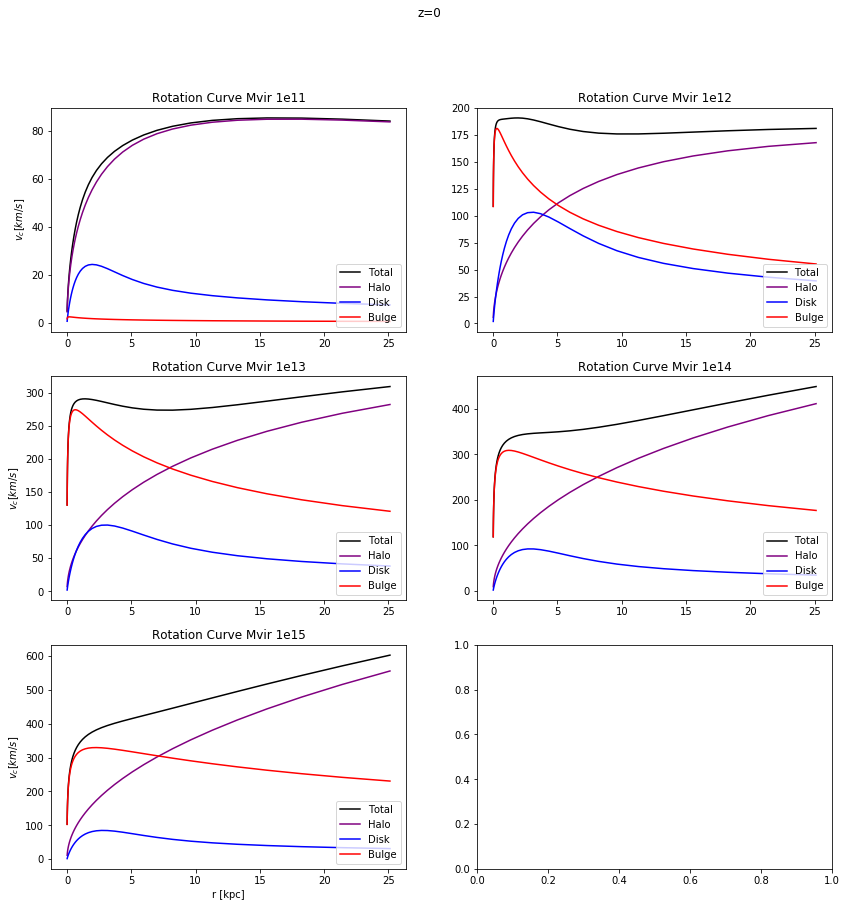

In [14]:
################################Figures#############################################


###################Circular velocity################################


z= 0.
Mvir = (1e11,1e12,1e13,1e14,1e15)
Ms = SHMR(z,Mvir[0])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot = []
vel_d = []
vel_sph = []
vel_halo = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot.append(circ_vel_total(Mvir[0], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo.append(circ_vel_halo(Mvir[0], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d.append(circ_vel_disk(Md, r, z))
    vel_sph.append(circ_vel_bulge(Msph, r, z))



Ms = SHMR(z,Mvir[1])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot1 = []
vel_d1 = []
vel_sph1 = []
vel_halo1 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot1.append(circ_vel_total(Mvir[1], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo1.append(circ_vel_halo(Mvir[1], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d1.append(circ_vel_disk(Md, r, z))
    vel_sph1.append(circ_vel_bulge(Msph, r, z))


Ms = SHMR(z,Mvir[2])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot2 = []
vel_d2 = []
vel_sph2 = []
vel_halo2 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot2.append(circ_vel_total(Mvir[2], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo2.append(circ_vel_halo(Mvir[2], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d2.append(circ_vel_disk(Md, r, z))
    vel_sph2.append(circ_vel_bulge(Msph, r, z))


Ms = SHMR(z,Mvir[3])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot3 = []
vel_d3 = []
vel_sph3 = []
vel_halo3 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot3.append(circ_vel_total(Mvir[3], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo3.append(circ_vel_halo(Mvir[3], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d3.append(circ_vel_disk(Md, r, z))
    vel_sph3.append(circ_vel_bulge(Msph, r, z))


Ms = SHMR(z,Mvir[4])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot4 = []
vel_d4 = []
vel_sph4 = []
vel_halo4 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot4.append(circ_vel_total(Mvir[4], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo4.append(circ_vel_halo(Mvir[4], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d4.append(circ_vel_disk(Md, r, z))
    vel_sph4.append(circ_vel_bulge(Msph, r, z))



fig, ax = plt.subplots(3, 2, figsize=(14, 14))
fig.suptitle('z=0')

ax[0][0].set_title('Rotation Curve Mvir 1e11')
ax[0][0].plot(radius, vel_tot, '-k', color='black', label='Total')
ax[0][0].plot(radius, vel_halo, '-k', color='purple', label='Halo')
ax[0][0].plot(radius, vel_d, '-k', color='blue', label='Disk')
ax[0][0].plot(radius, vel_sph, '-k', color='red', label='Bulge')
ax[0][0].set_ylabel('$v_c[km/s]$')
ax[0][0].legend(loc='lower right')

ax[0][1].set_title('Rotation Curve Mvir 1e12')
ax[0][1].plot(radius, vel_tot1, '-k', color='black', label='Total')
ax[0][1].plot(radius, vel_halo1, '-k', color='purple', label='Halo')
ax[0][1].plot(radius, vel_d1, '-k', color='blue', label='Disk')
ax[0][1].plot(radius, vel_sph1, '-k', color='red', label='Bulge')

ax[0][1].legend(loc='lower right')


ax[1][0].set_title('Rotation Curve Mvir 1e13')
ax[1][0].plot(radius, vel_tot2, '-k', color='black', label='Total')
ax[1][0].plot(radius, vel_halo2, '-k', color='purple', label='Halo')
ax[1][0].plot(radius, vel_d2, '-k', color='blue', label='Disk')
ax[1][0].plot(radius, vel_sph2, '-k', color='red', label='Bulge')
ax[1][0].set_ylabel('$v_c[km/s]$')
ax[1][0].legend(loc='lower right')


ax[1][1].set_title('Rotation Curve Mvir 1e14')
ax[1][1].plot(radius, vel_tot3, '-k', color='black', label='Total')
ax[1][1].plot(radius, vel_halo3, '-k', color='purple', label='Halo')
ax[1][1].plot(radius, vel_d3, '-k', color='blue', label='Disk')
ax[1][1].plot(radius, vel_sph3, '-k', color='red', label='Bulge')

ax[1][1].legend(loc='lower right')


ax[2][0].set_title('Rotation Curve Mvir 1e15')
ax[2][0].plot(radius, vel_tot4, '-k', color='black', label='Total')
ax[2][0].plot(radius, vel_halo4, '-k', color='purple', label='Halo')
ax[2][0].plot(radius, vel_d4, '-k', color='blue', label='Disk')
ax[2][0].plot(radius, vel_sph4, '-k', color='red', label='Bulge')
ax[2][0].set_xlabel('r [kpc]')
ax[2][0].set_ylabel('$v_c[km/s]$')
ax[2][0].legend(loc='lower right')

plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/rot_curves_z0.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()




In [ ]:

z= 0.5
Mvir = (1e11,1e12,1e13,1e14,1e15)
Ms = SHMR(z,Mvir[0])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot = []
vel_d = []
vel_sph = []
vel_halo = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot.append(circ_vel_total(Mvir[0], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo.append(circ_vel_halo(Mvir[0], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d.append(circ_vel_disk(Md, r, z))
    vel_sph.append(circ_vel_bulge(Msph, r, z))



Ms = SHMR(z,Mvir[1])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot1 = []
vel_d1 = []
vel_sph1 = []
vel_halo1 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot1.append(circ_vel_total(Mvir[1], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo1.append(circ_vel_halo(Mvir[1], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d1.append(circ_vel_disk(Md, r, z))
    vel_sph1.append(circ_vel_bulge(Msph, r, z))


Ms = SHMR(z,Mvir[2])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot2 = []
vel_d2 = []
vel_sph2 = []
vel_halo2 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot2.append(circ_vel_total(Mvir[2], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo2.append(circ_vel_halo(Mvir[2], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d2.append(circ_vel_disk(Md, r, z))
    vel_sph2.append(circ_vel_bulge(Msph, r, z))


Ms = SHMR(z,Mvir[3])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot3 = []
vel_d3 = []
vel_sph3 = []
vel_halo3 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot3.append(circ_vel_total(Mvir[3], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo3.append(circ_vel_halo(Mvir[3], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d3.append(circ_vel_disk(Md, r, z))
    vel_sph3.append(circ_vel_bulge(Msph, r, z))


Ms = SHMR(z,Mvir[4])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot4 = []
vel_d4 = []
vel_sph4 = []
vel_halo4 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot4.append(circ_vel_total(Mvir[4], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo4.append(circ_vel_halo(Mvir[4], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d4.append(circ_vel_disk(Md, r, z))
    vel_sph4.append(circ_vel_bulge(Msph, r, z))



fig, ax = plt.subplots(3, 2, figsize=(14, 14))
fig.suptitle('z=0.5')

ax[0][0].set_title('Rotation Curve Mvir 1e11')
ax[0][0].plot(radius, vel_tot, '-k', color='black', label='Total')
ax[0][0].plot(radius, vel_halo, '-k', color='purple', label='Halo')
ax[0][0].plot(radius, vel_d, '-k', color='blue', label='Disk')
ax[0][0].plot(radius, vel_sph, '-k', color='red', label='Bulge')
ax[0][0].set_ylabel('$v_c[km/s]$')
ax[0][0].legend(loc='lower right')

ax[0][1].set_title('Rotation Curve Mvir 1e12')
ax[0][1].plot(radius, vel_tot1, '-k', color='black', label='Total')
ax[0][1].plot(radius, vel_halo1, '-k', color='purple', label='Halo')
ax[0][1].plot(radius, vel_d1, '-k', color='blue', label='Disk')
ax[0][1].plot(radius, vel_sph1, '-k', color='red', label='Bulge')

ax[0][1].legend(loc='lower right')


ax[1][0].set_title('Rotation Curve Mvir 1e13')
ax[1][0].plot(radius, vel_tot2, '-k', color='black', label='Total')
ax[1][0].plot(radius, vel_halo2, '-k', color='purple', label='Halo')
ax[1][0].plot(radius, vel_d2, '-k', color='blue', label='Disk')
ax[1][0].plot(radius, vel_sph2, '-k', color='red', label='Bulge')
ax[1][0].set_ylabel('$v_c[km/s]$')
ax[1][0].legend(loc='lower right')


ax[1][1].set_title('Rotation Curve Mvir 1e14')
ax[1][1].plot(radius, vel_tot3, '-k', color='black', label='Total')
ax[1][1].plot(radius, vel_halo3, '-k', color='purple', label='Halo')
ax[1][1].plot(radius, vel_d3, '-k', color='blue', label='Disk')
ax[1][1].plot(radius, vel_sph3, '-k', color='red', label='Bulge')

ax[1][1].legend(loc='lower right')


ax[2][0].set_title('Rotation Curve Mvir 1e15')
ax[2][0].plot(radius, vel_tot4, '-k', color='black', label='Total')
ax[2][0].plot(radius, vel_halo4, '-k', color='purple', label='Halo')
ax[2][0].plot(radius, vel_d4, '-k', color='blue', label='Disk')
ax[2][0].plot(radius, vel_sph4, '-k', color='red', label='Bulge')
ax[2][0].set_xlabel('r [kpc]')
ax[2][0].set_ylabel('$v_c[km/s]$')
ax[2][0].legend(loc='lower right')

plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/rot_curves_z0.5.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

In [ ]:

z= 1.
Mvir = (1e11,1e12,1e13,1e14,1e15)
Ms = SHMR(z,Mvir[0])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot = []
vel_d = []
vel_sph = []
vel_halo = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot.append(circ_vel_total(Mvir[0], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo.append(circ_vel_halo(Mvir[0], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d.append(circ_vel_disk(Md, r, z))
    vel_sph.append(circ_vel_bulge(Msph, r, z))



Ms = SHMR(z,Mvir[1])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot1 = []
vel_d1 = []
vel_sph1 = []
vel_halo1 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot1.append(circ_vel_total(Mvir[1], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo1.append(circ_vel_halo(Mvir[1], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d1.append(circ_vel_disk(Md, r, z))
    vel_sph1.append(circ_vel_bulge(Msph, r, z))


Ms = SHMR(z,Mvir[2])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot2 = []
vel_d2 = []
vel_sph2 = []
vel_halo2 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot2.append(circ_vel_total(Mvir[2], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo2.append(circ_vel_halo(Mvir[2], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d2.append(circ_vel_disk(Md, r, z))
    vel_sph2.append(circ_vel_bulge(Msph, r, z))


Ms = SHMR(z,Mvir[3])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot3 = []
vel_d3 = []
vel_sph3 = []
vel_halo3 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot3.append(circ_vel_total(Mvir[3], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo3.append(circ_vel_halo(Mvir[3], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d3.append(circ_vel_disk(Md, r, z))
    vel_sph3.append(circ_vel_bulge(Msph, r, z))


Ms = SHMR(z,Mvir[4])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot4 = []
vel_d4 = []
vel_sph4 = []
vel_halo4 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot4.append(circ_vel_total(Mvir[4], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo4.append(circ_vel_halo(Mvir[4], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d4.append(circ_vel_disk(Md, r, z))
    vel_sph4.append(circ_vel_bulge(Msph, r, z))



fig, ax = plt.subplots(3, 2, figsize=(14, 14))
fig.suptitle('z=1')

ax[0][0].set_title('Rotation Curve Mvir 1e11')
ax[0][0].plot(radius, vel_tot, '-k', color='black', label='Total')
ax[0][0].plot(radius, vel_halo, '-k', color='purple', label='Halo')
ax[0][0].plot(radius, vel_d, '-k', color='blue', label='Disk')
ax[0][0].plot(radius, vel_sph, '-k', color='red', label='Bulge')
ax[0][0].set_ylabel('$v_c[km/s]$')
ax[0][0].legend(loc='lower right')

ax[0][1].set_title('Rotation Curve Mvir 1e12')
ax[0][1].plot(radius, vel_tot1, '-k', color='black', label='Total')
ax[0][1].plot(radius, vel_halo1, '-k', color='purple', label='Halo')
ax[0][1].plot(radius, vel_d1, '-k', color='blue', label='Disk')
ax[0][1].plot(radius, vel_sph1, '-k', color='red', label='Bulge')

ax[0][1].legend(loc='lower right')


ax[1][0].set_title('Rotation Curve Mvir 1e13')
ax[1][0].plot(radius, vel_tot2, '-k', color='black', label='Total')
ax[1][0].plot(radius, vel_halo2, '-k', color='purple', label='Halo')
ax[1][0].plot(radius, vel_d2, '-k', color='blue', label='Disk')
ax[1][0].plot(radius, vel_sph2, '-k', color='red', label='Bulge')
ax[1][0].set_ylabel('$v_c[km/s]$')
ax[1][0].legend(loc='lower right')


ax[1][1].set_title('Rotation Curve Mvir 1e14')
ax[1][1].plot(radius, vel_tot3, '-k', color='black', label='Total')
ax[1][1].plot(radius, vel_halo3, '-k', color='purple', label='Halo')
ax[1][1].plot(radius, vel_d3, '-k', color='blue', label='Disk')
ax[1][1].plot(radius, vel_sph3, '-k', color='red', label='Bulge')

ax[1][1].legend(loc='lower right')


ax[2][0].set_title('Rotation Curve Mvir 1e15')
ax[2][0].plot(radius, vel_tot4, '-k', color='black', label='Total')
ax[2][0].plot(radius, vel_halo4, '-k', color='purple', label='Halo')
ax[2][0].plot(radius, vel_d4, '-k', color='blue', label='Disk')
ax[2][0].plot(radius, vel_sph4, '-k', color='red', label='Bulge')
ax[2][0].set_xlabel('r [kpc]')
ax[2][0].set_ylabel('$v_c[km/s]$')
ax[2][0].legend(loc='lower right')

plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/rot_curves_z1.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

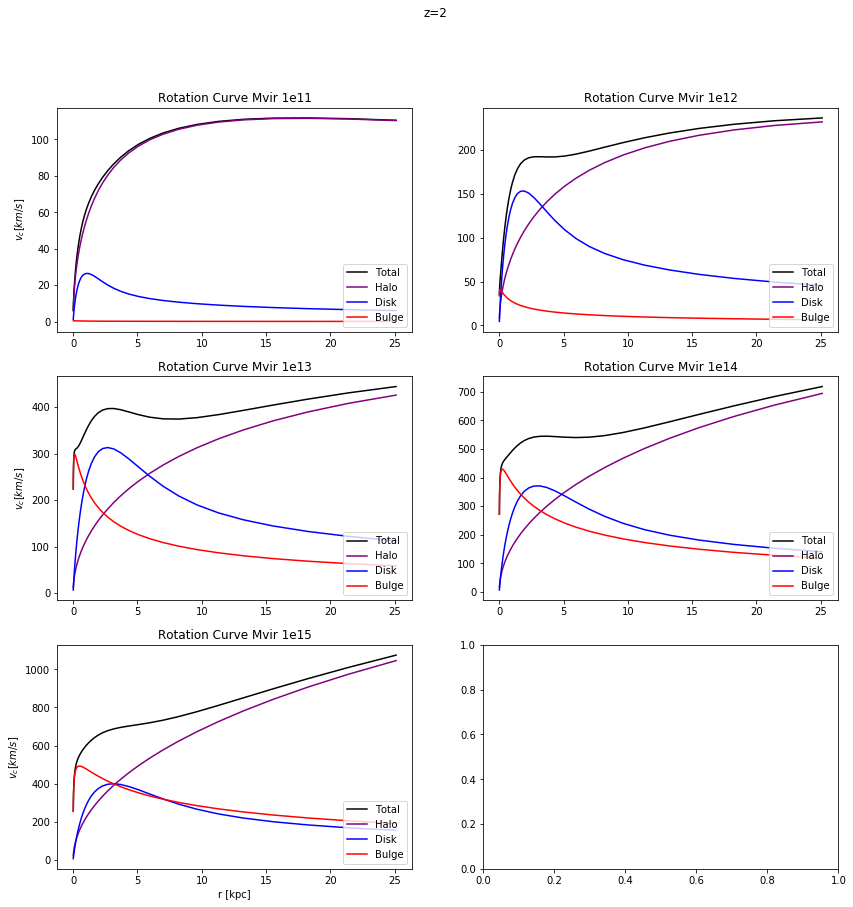

In [18]:

z= 2.
Mvir = (1e11,1e12,1e13,1e14,1e15)
Ms = SHMR(z,Mvir[0])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot = []
vel_d = []
vel_sph = []
vel_halo = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot.append(circ_vel_total(Mvir[0], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo.append(circ_vel_halo(Mvir[0], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d.append(circ_vel_disk(Md, r, z))
    vel_sph.append(circ_vel_bulge(Msph, r, z))



Ms = SHMR(z,Mvir[1])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot1 = []
vel_d1 = []
vel_sph1 = []
vel_halo1 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot1.append(circ_vel_total(Mvir[1], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo1.append(circ_vel_halo(Mvir[1], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d1.append(circ_vel_disk(Md, r, z))
    vel_sph1.append(circ_vel_bulge(Msph, r, z))


Ms = SHMR(z,Mvir[2])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot2 = []
vel_d2 = []
vel_sph2 = []
vel_halo2 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot2.append(circ_vel_total(Mvir[2], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo2.append(circ_vel_halo(Mvir[2], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d2.append(circ_vel_disk(Md, r, z))
    vel_sph2.append(circ_vel_bulge(Msph, r, z))


Ms = SHMR(z,Mvir[3])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot3 = []
vel_d3 = []
vel_sph3 = []
vel_halo3 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot3.append(circ_vel_total(Mvir[3], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo3.append(circ_vel_halo(Mvir[3], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d3.append(circ_vel_disk(Md, r, z))
    vel_sph3.append(circ_vel_bulge(Msph, r, z))


Ms = SHMR(z,Mvir[4])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot4 = []
vel_d4 = []
vel_sph4 = []
vel_halo4 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot4.append(circ_vel_total(Mvir[4], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo4.append(circ_vel_halo(Mvir[4], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d4.append(circ_vel_disk(Md, r, z))
    vel_sph4.append(circ_vel_bulge(Msph, r, z))



fig, ax = plt.subplots(3, 2, figsize=(14, 14))
fig.suptitle('z=2')

ax[0][0].set_title('Rotation Curve Mvir 1e11')
ax[0][0].plot(radius, vel_tot, '-k', color='black', label='Total')
ax[0][0].plot(radius, vel_halo, '-k', color='purple', label='Halo')
ax[0][0].plot(radius, vel_d, '-k', color='blue', label='Disk')
ax[0][0].plot(radius, vel_sph, '-k', color='red', label='Bulge')
ax[0][0].set_ylabel('$v_c[km/s]$')
ax[0][0].legend(loc='lower right')

ax[0][1].set_title('Rotation Curve Mvir 1e12')
ax[0][1].plot(radius, vel_tot1, '-k', color='black', label='Total')
ax[0][1].plot(radius, vel_halo1, '-k', color='purple', label='Halo')
ax[0][1].plot(radius, vel_d1, '-k', color='blue', label='Disk')
ax[0][1].plot(radius, vel_sph1, '-k', color='red', label='Bulge')

ax[0][1].legend(loc='lower right')


ax[1][0].set_title('Rotation Curve Mvir 1e13')
ax[1][0].plot(radius, vel_tot2, '-k', color='black', label='Total')
ax[1][0].plot(radius, vel_halo2, '-k', color='purple', label='Halo')
ax[1][0].plot(radius, vel_d2, '-k', color='blue', label='Disk')
ax[1][0].plot(radius, vel_sph2, '-k', color='red', label='Bulge')
ax[1][0].set_ylabel('$v_c[km/s]$')
ax[1][0].legend(loc='lower right')


ax[1][1].set_title('Rotation Curve Mvir 1e14')
ax[1][1].plot(radius, vel_tot3, '-k', color='black', label='Total')
ax[1][1].plot(radius, vel_halo3, '-k', color='purple', label='Halo')
ax[1][1].plot(radius, vel_d3, '-k', color='blue', label='Disk')
ax[1][1].plot(radius, vel_sph3, '-k', color='red', label='Bulge')

ax[1][1].legend(loc='lower right')


ax[2][0].set_title('Rotation Curve Mvir 1e15')
ax[2][0].plot(radius, vel_tot4, '-k', color='black', label='Total')
ax[2][0].plot(radius, vel_halo4, '-k', color='purple', label='Halo')
ax[2][0].plot(radius, vel_d4, '-k', color='blue', label='Disk')
ax[2][0].plot(radius, vel_sph4, '-k', color='red', label='Bulge')
ax[2][0].set_xlabel('r [kpc]')
ax[2][0].set_ylabel('$v_c[km/s]$')
ax[2][0].legend(loc='lower right')

plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/rot_curves_z2.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

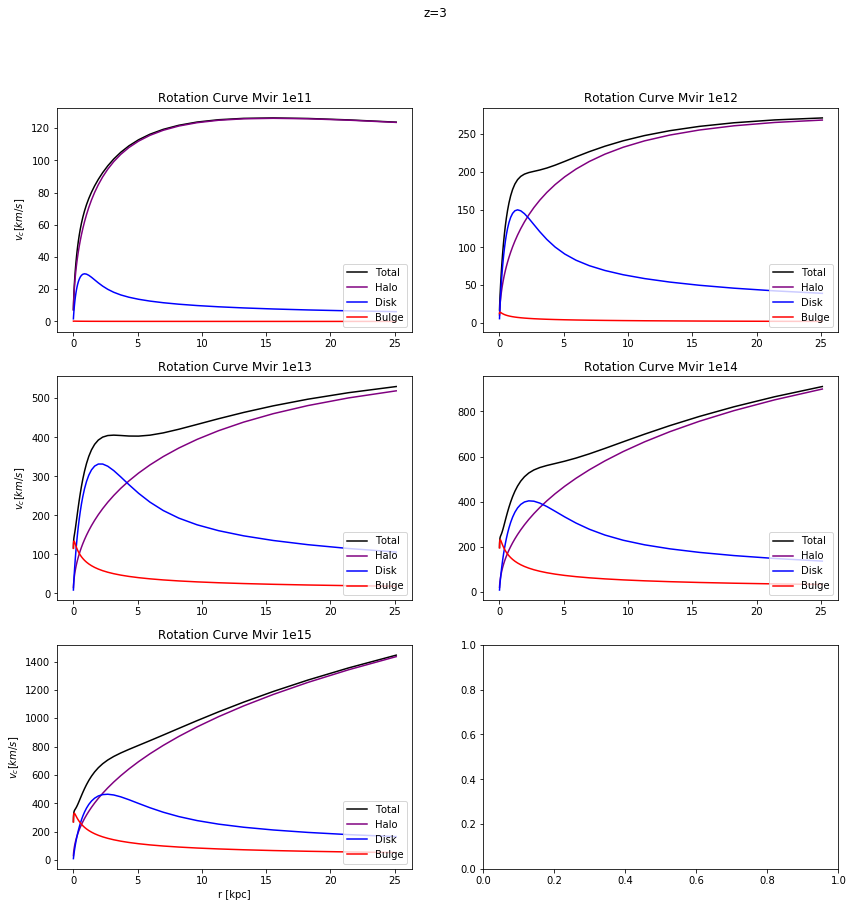

In [19]:

z= 3.
Mvir = (1e11,1e12,1e13,1e14,1e15)
Ms = SHMR(z,Mvir[0])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot = []
vel_d = []
vel_sph = []
vel_halo = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot.append(circ_vel_total(Mvir[0], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo.append(circ_vel_halo(Mvir[0], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d.append(circ_vel_disk(Md, r, z))
    vel_sph.append(circ_vel_bulge(Msph, r, z))



Ms = SHMR(z,Mvir[1])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot1 = []
vel_d1 = []
vel_sph1 = []
vel_halo1 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot1.append(circ_vel_total(Mvir[1], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo1.append(circ_vel_halo(Mvir[1], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d1.append(circ_vel_disk(Md, r, z))
    vel_sph1.append(circ_vel_bulge(Msph, r, z))


Ms = SHMR(z,Mvir[2])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot2 = []
vel_d2 = []
vel_sph2 = []
vel_halo2 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot2.append(circ_vel_total(Mvir[2], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo2.append(circ_vel_halo(Mvir[2], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d2.append(circ_vel_disk(Md, r, z))
    vel_sph2.append(circ_vel_bulge(Msph, r, z))


Ms = SHMR(z,Mvir[3])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot3 = []
vel_d3 = []
vel_sph3 = []
vel_halo3 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot3.append(circ_vel_total(Mvir[3], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo3.append(circ_vel_halo(Mvir[3], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d3.append(circ_vel_disk(Md, r, z))
    vel_sph3.append(circ_vel_bulge(Msph, r, z))


Ms = SHMR(z,Mvir[4])
Md = fSF(Ms,z) * Ms
Msph = (1. - fSF(Ms,z)) * Ms
vel_tot4 = []
vel_d4 = []
vel_sph4 = []
vel_halo4 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    vel_tot4.append(circ_vel_total(Mvir[4], Ms, r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_halo4.append(circ_vel_halo(Mvir[4], r,  Om_mat_cero, Om_lambda_cero, z, h))
    vel_d4.append(circ_vel_disk(Md, r, z))
    vel_sph4.append(circ_vel_bulge(Msph, r, z))



fig, ax = plt.subplots(3, 2, figsize=(14, 14))
fig.suptitle('z=3')

ax[0][0].set_title('Rotation Curve Mvir 1e11')
ax[0][0].plot(radius, vel_tot, '-k', color='black', label='Total')
ax[0][0].plot(radius, vel_halo, '-k', color='purple', label='Halo')
ax[0][0].plot(radius, vel_d, '-k', color='blue', label='Disk')
ax[0][0].plot(radius, vel_sph, '-k', color='red', label='Bulge')
ax[0][0].set_ylabel('$v_c[km/s]$')
ax[0][0].legend(loc='lower right')

ax[0][1].set_title('Rotation Curve Mvir 1e12')
ax[0][1].plot(radius, vel_tot1, '-k', color='black', label='Total')
ax[0][1].plot(radius, vel_halo1, '-k', color='purple', label='Halo')
ax[0][1].plot(radius, vel_d1, '-k', color='blue', label='Disk')
ax[0][1].plot(radius, vel_sph1, '-k', color='red', label='Bulge')

ax[0][1].legend(loc='lower right')


ax[1][0].set_title('Rotation Curve Mvir 1e13')
ax[1][0].plot(radius, vel_tot2, '-k', color='black', label='Total')
ax[1][0].plot(radius, vel_halo2, '-k', color='purple', label='Halo')
ax[1][0].plot(radius, vel_d2, '-k', color='blue', label='Disk')
ax[1][0].plot(radius, vel_sph2, '-k', color='red', label='Bulge')
ax[1][0].set_ylabel('$v_c[km/s]$')
ax[1][0].legend(loc='lower right')


ax[1][1].set_title('Rotation Curve Mvir 1e14')
ax[1][1].plot(radius, vel_tot3, '-k', color='black', label='Total')
ax[1][1].plot(radius, vel_halo3, '-k', color='purple', label='Halo')
ax[1][1].plot(radius, vel_d3, '-k', color='blue', label='Disk')
ax[1][1].plot(radius, vel_sph3, '-k', color='red', label='Bulge')

ax[1][1].legend(loc='lower right')


ax[2][0].set_title('Rotation Curve Mvir 1e15')
ax[2][0].plot(radius, vel_tot4, '-k', color='black', label='Total')
ax[2][0].plot(radius, vel_halo4, '-k', color='purple', label='Halo')
ax[2][0].plot(radius, vel_d4, '-k', color='blue', label='Disk')
ax[2][0].plot(radius, vel_sph4, '-k', color='red', label='Bulge')
ax[2][0].set_xlabel('r [kpc]')
ax[2][0].set_ylabel('$v_c[km/s]$')
ax[2][0].legend(loc='lower right')

plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/rot_curves_z3.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

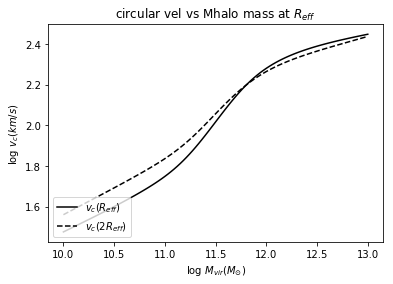

In [15]:
###################Circular velocity################################

z1= 0.
Mhalo = np.logspace(10, 13, 100)
vc1=[]
vc2=[]
for i in range(0, 100):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    reff_all1 = avg_rad_eff(m_s1, z1)
    vc1.append(circ_vel_total(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, h))
    vc2.append(circ_vel_total(m_v, m_s1, 2 *reff_all1,  Om_mat_cero, Om_lambda_cero, z1, h))


plt.title('circular vel vs Mhalo mass at $R_{eff}$')
plt.plot(np.log10(Mhalo), np.log10(vc1), '-k', color='black', label='$v_c(R_{eff})$')
plt.plot(np.log10(Mhalo), np.log10(vc2), '--k', color='black', label='$v_c(2R_{eff})$')
plt.xlabel('log $M_{vir} (M_{\odot})$')
plt.ylabel('log $v_c(km/s)$')
plt.legend(loc='lower left')
plt.show()

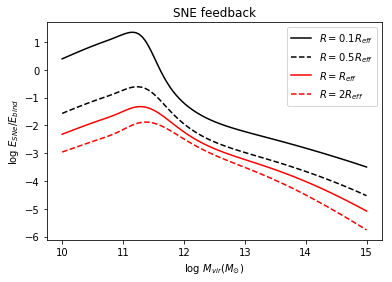

In [22]:
###################Feedbakc as a function of halo mass################################

z1= 0.
Mhalo = np.logspace(10, 15, 100)
sne_feedbck1=[]
sne_feedbck2=[]
sne_feedbck3=[]
sne_feedbck4=[]
for i in range(0, 100):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    reff_all1 = avg_rad_eff(m_s1, z1)
    sne_feedbck1.append(SNE_feedback(m_v, m_s1, 0.1*reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    sne_feedbck2.append(SNE_feedback(m_v, m_s1, 0.5*reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    sne_feedbck3.append(SNE_feedback(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    sne_feedbck4.append(SNE_feedback(m_v, m_s1, 2*reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))


plt.title('SNE feedback')
plt.plot(np.log10(Mhalo), np.log10(sne_feedbck1), '-k', color='black', label='$ R = 0.1 R_{eff}$')
plt.plot(np.log10(Mhalo), np.log10(sne_feedbck2), '--k', color='black', label='$ R = 0.5 R_{eff} $')
plt.plot(np.log10(Mhalo), np.log10(sne_feedbck3), '-k', color='red', label='$ R = R_{eff}$')
plt.plot(np.log10(Mhalo), np.log10(sne_feedbck4), '--k', color='red', label='$ R = 2 R_{eff}$')
plt.xlabel('log $M_{vir} (M_{\odot})$')
plt.ylabel('log $E_{SNe}/E_{bind}$')
plt.legend(loc='upper right')
plt.show()

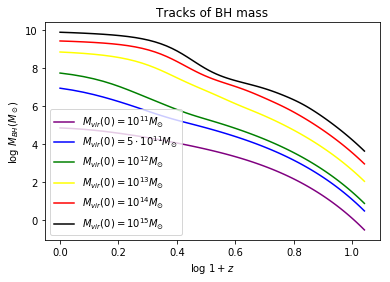

In [17]:
###################BH growth################################

z0 = 0.
Mvir0 = [1e11,5e11,1e12,1e13,1e14,1e15]
redshift = np.linspace (z0, 10, 100)
M_bh_mse1 = average_MBH_Ms_relation(Mvir0[0],z0, redshift)
M_bh_mse2 = average_MBH_Ms_relation(Mvir0[1],z0, redshift)
M_bh_mse3 = average_MBH_Ms_relation(Mvir0[2],z0, redshift)
M_bh_mse4 = average_MBH_Ms_relation(Mvir0[3],z0, redshift)
M_bh_mse5 = average_MBH_Ms_relation(Mvir0[4],z0, redshift)
M_bh_mse6 = average_MBH_Ms_relation(Mvir0[5],z0, redshift)

plt.title('Tracks of BH mass')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse1), '-', color='purple', label='$M_{vir}(0)=10^{11}M_{\odot}$')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse2), '-', color='blue', label='$M_{vir}(0)=5\cdot 10^{11}M_{\odot}$')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse3), '-', color='green', label='$M_{vir}(0)=10^{12}M_{\odot}$')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse4), '-', color='yellow', label='$M_{vir}(0)=10^{13}M_{\odot}$')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse5), '-', color='red', label='$M_{vir}(0)=10^{14}M_{\odot}$')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse6), '-', color='black', label='$M_{vir}(0)=10^{15}M_{\odot}$')
plt.xlabel('log $1+z$')
plt.ylabel('log $M_{BH} (M_\odot$)')
plt.legend(loc='lower left')
plt.show()

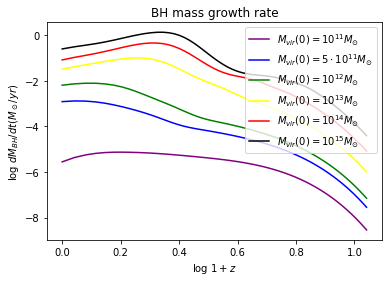

In [18]:
###################BH rate growth################################

z0 = 0.
Mvir0 = [1e11,5e11,1e12,1e13,1e14,1e15]
z = np.linspace (0, 10, 100)
dmbhdt1 = []
dmbhdt2 = []
dmbhdt3 = []
dmbhdt4 = []
dmbhdt5 = []
dmbhdt6 = []
for i in range(0, 100):
    redshift = z[i]
    dmbhdt1.append(dMBH_dt(Mvir0[0],z0,redshift))
    dmbhdt2.append(dMBH_dt(Mvir0[1],z0,redshift))
    dmbhdt3.append(dMBH_dt(Mvir0[2],z0,redshift))
    dmbhdt4.append(dMBH_dt(Mvir0[3],z0,redshift))
    dmbhdt5.append(dMBH_dt(Mvir0[4],z0,redshift))
    dmbhdt6.append(dMBH_dt(Mvir0[5],z0,redshift))

plt.title('BH mass growth rate')
plt.plot(np.log10(1+z), np.log10(dmbhdt1), '-k', color='purple', label='$M_{vir}(0)=10^{11}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(dmbhdt2), '-k', color='blue', label='$M_{vir}(0)=5\cdot 10^{11}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(dmbhdt3), '-k', color='green', label='$M_{vir}(0)=10^{12}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(dmbhdt4), '-k', color='yellow', label='$M_{vir}(0)=10^{13}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(dmbhdt5), '-k', color='red', label='$M_{vir}(0)=10^{14}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(dmbhdt6), '-k', color='black', label='$M_{vir}(0)=10^{15}M_{\odot}$')
plt.xlabel('log $1+z$')
plt.ylabel('log $d M_{BH}/dt (M_\odot/yr)$')
plt.legend(loc='upper right')
plt.show()

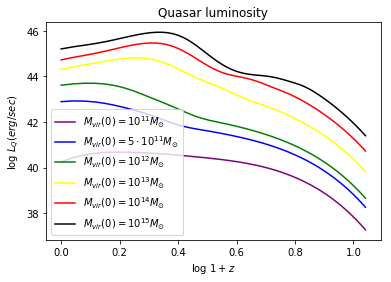

In [19]:
###################Quasar Lumonosity################################

Lum_q_s1= []
Lum_q_s2= []
Lum_q_s3= []
Lum_q_s4= []
Lum_q_s5= []
Lum_q_s6= []
z0 = 0.
Mvir0 = [1e11,5e11,1e12,1e13,1e14,1e15]
z = np.linspace (0, 10, 100)
for i in range(0, 100):
    redshift = z[i]
    Lum_q_s1.append(Lum_quasar(Mvir0[0], z0, redshift))
    Lum_q_s2.append(Lum_quasar(Mvir0[1], z0, redshift))
    Lum_q_s3.append(Lum_quasar(Mvir0[2], z0, redshift))
    Lum_q_s4.append(Lum_quasar(Mvir0[3], z0, redshift))
    Lum_q_s5.append(Lum_quasar(Mvir0[4], z0, redshift))
    Lum_q_s6.append(Lum_quasar(Mvir0[5], z0, redshift))


plt.title('Quasar luminosity')
plt.plot(np.log10(1+z), np.log10(Lum_q_s1), '-', color='purple', label='$M_{vir}(0)=10^{11}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(Lum_q_s2), '-', color='blue', label='$M_{vir}(0)=5\cdot10^{11}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(Lum_q_s3), '-', color='green', label='$M_{vir}(0)=10^{12}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(Lum_q_s4), '-', color='yellow', label='$M_{vir}(0)=10^{13}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(Lum_q_s5), '-', color='red', label='$M_{vir}(0)=10^{14}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(Lum_q_s6), '-', color='black', label='$M_{vir}(0)=10^{15}M_{\odot}$')
plt.xlabel('log $1+z$')
plt.ylabel('log $L_Q (erg/sec)$')
plt.legend(loc='lower left')
plt.show()

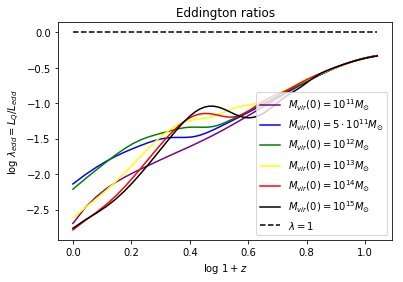

In [20]:
###################Eddington ratios################################

z = np.linspace (0, 10, 100)
z0 = 0.
Mvir0 = [1e11,5e11,1e12,1e13,1e14,1e15]
ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]
ratio6=[]

y0 = z*0

for i in range(0, 100):
    redshift = z[i]
    ratio1.append(Lum_quasar(Mvir0[0], z0, redshift)/ Lum_eddigton(Mvir0[0], z0, redshift))
    ratio2.append(Lum_quasar(Mvir0[1], z0, redshift)/ Lum_eddigton(Mvir0[1], z0, redshift))
    ratio3.append(Lum_quasar(Mvir0[2], z0, redshift)/ Lum_eddigton(Mvir0[2], z0, redshift))
    ratio4.append(Lum_quasar(Mvir0[3], z0, redshift)/ Lum_eddigton(Mvir0[3], z0, redshift))
    ratio5.append(Lum_quasar(Mvir0[4], z0, redshift)/ Lum_eddigton(Mvir0[4], z0, redshift))
    ratio6.append(Lum_quasar(Mvir0[5], z0, redshift)/ Lum_eddigton(Mvir0[5], z0, redshift))



plt.title('Eddington ratios')
plt.plot(np.log10(1+z), np.log10(ratio1), '-', color='purple', label='$M_{vir}(0)=10^{11}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(ratio2), '-', color='blue', label='$M_{vir}(0)=5\cdot 10^{11}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(ratio3), '-', color='green', label='$M_{vir}(0)=10^{12}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(ratio4), '-', color='yellow', label='$M_{vir}(0)=10^{13}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(ratio5), '-', color='red', label='$M_{vir}(0)=10^{14}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(ratio6), '-', color='black', label='$M_{vir}(0)=10^{15}M_{\odot}$')
plt.plot(np.log10(1+z), y0, '--', color='black', label='$\lambda = 1$')
plt.xlabel('log $1+z$')
plt.ylabel('log $\lambda_{edd} = L_Q/L_{edd}$')
plt.legend(loc='lower right')
plt.show()

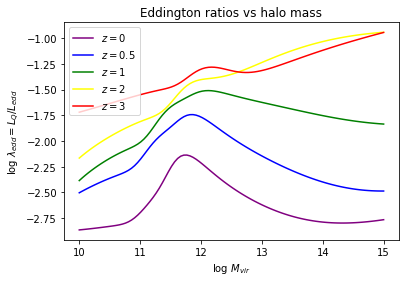

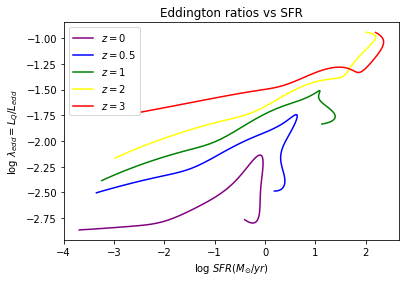

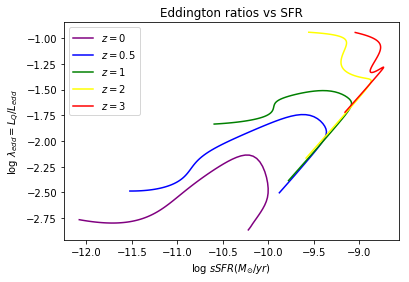

In [21]:
###################Eddington ratios function of mass################################

z1= 0.
z2= 0.5
z3= 1.
z4= 2.
z5= 3.


Mhalo = np.logspace(10, 15, 100)

ratio1=[]
ratio2=[]
ratio3=[]
ratio4=[]
ratio5=[]

SFR1=[]
SFR2=[]
SFR3=[]
SFR4=[]
SFR5=[]

ssfr1=[]
ssfr2=[]
ssfr3=[]
ssfr4=[]
ssfr5=[]


for i in range(0, 100):
    m_v = Mhalo[i]
    ratio1.append(Lum_quasar(m_v, z1, z1)/ Lum_eddigton(m_v, z1, z1))
    ratio2.append(Lum_quasar(m_v, z2, z2)/ Lum_eddigton(m_v, z2, z2))
    ratio3.append(Lum_quasar(m_v, z3, z3)/ Lum_eddigton(m_v, z3, z3))
    ratio4.append(Lum_quasar(m_v, z4, z4)/ Lum_eddigton(m_v, z4, z4))
    ratio5.append(Lum_quasar(m_v, z5, z5)/ Lum_eddigton(m_v, z5, z5))
    SFR1.append(SFR(m_v, z1, z1))
    SFR2.append(SFR(m_v, z2, z2))
    SFR3.append(SFR(m_v, z3, z3))
    SFR4.append(SFR(m_v, z4, z4))
    SFR5.append(SFR(m_v, z5, z5))
    ssfr1.append(SFR(m_v, z1, z1)/SHMR(z1,m_v))
    ssfr2.append(SFR(m_v, z2, z2)/SHMR(z2,m_v))
    ssfr3.append(SFR(m_v, z3, z3)/SHMR(z3,m_v))
    ssfr4.append(SFR(m_v, z4, z4)/SHMR(z4,m_v))
    ssfr5.append(SFR(m_v, z5, z5)/SHMR(z5,m_v))



plt.title('Eddington ratios vs halo mass')
plt.plot(np.log10(Mhalo), np.log10(ratio1), '-', color='purple', label='$z=0$')
plt.plot(np.log10(Mhalo), np.log10(ratio2), '-', color='blue', label='$z=0.5$')
plt.plot(np.log10(Mhalo), np.log10(ratio3), '-', color='green', label='$z=1$')
plt.plot(np.log10(Mhalo), np.log10(ratio4), '-', color='yellow', label='$z=2$')
plt.plot(np.log10(Mhalo), np.log10(ratio5), '-', color='red', label='$z=3$')
plt.xlabel('log $M_{vir}$')
plt.ylabel('log $\lambda_{edd} = L_Q/L_{edd}$')
plt.legend(loc='upper left')
plt.show()


plt.title('Eddington ratios vs SFR')
plt.plot(np.log10(SFR1), np.log10(ratio1), '-', color='purple', label='$z=0$')
plt.plot(np.log10(SFR2), np.log10(ratio2), '-', color='blue', label='$z=0.5$')
plt.plot(np.log10(SFR3), np.log10(ratio3), '-', color='green', label='$z=1$')
plt.plot(np.log10(SFR4), np.log10(ratio4), '-', color='yellow', label='$z=2$')
plt.plot(np.log10(SFR5), np.log10(ratio5), '-', color='red', label='$z=3$')
plt.xlabel('log $SFR (M_{\odot}/yr)$ ')
plt.ylabel('log $\lambda_{edd} = L_Q/L_{edd}$')
plt.legend(loc='upper left')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/edd_ratio_sfr_shmr.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


plt.title('Eddington ratios vs SFR')
plt.plot(np.log10(ssfr1), np.log10(ratio1), '-', color='purple', label='$z=0$')
plt.plot(np.log10(ssfr2), np.log10(ratio2), '-', color='blue', label='$z=0.5$')
plt.plot(np.log10(ssfr3), np.log10(ratio3), '-', color='green', label='$z=1$')
plt.plot(np.log10(ssfr4), np.log10(ratio4), '-', color='yellow', label='$z=2$')
plt.plot(np.log10(ssfr5), np.log10(ratio5), '-', color='red', label='$z=3$')
plt.xlabel('log $sSFR (M_{\odot}/yr)$ ')
plt.ylabel('log $\lambda_{edd} = L_Q/L_{edd}$')
plt.legend(loc='upper left')
plt.savefig('/Users/ximena/Desktop/coding/Stellar_to_halo_evolution/edd_ratios_sfr.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

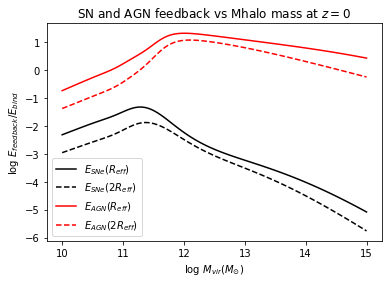

In [22]:
###################SNE feedback################################



z1= 0.


Mhalo = np.logspace(10, 15, 100)

SNE_f1=[]
SNE_f2=[]
AGN_f1=[]
AGN_f2=[]


for i in range(0, 100):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    reff_all1 = avg_rad_eff(m_s1, z1)
    SNE_f1.append(SNE_feedback(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    SNE_f2.append(SNE_feedback(m_v, m_s1, 2*reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    AGN_f1.append(AGN_feedback(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    AGN_f2.append(AGN_feedback(m_v, m_s1, 2*reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))




plt.title('SN and AGN feedback vs Mhalo mass at $z=0$')
plt.plot(np.log10(Mhalo), np.log10(SNE_f1), '-k', color='black', label='$E_{SNe}(R_{eff})$')
plt.plot(np.log10(Mhalo), np.log10(SNE_f2), '--k', color='black', label='$E_{SNe}(2R_{eff})$')
plt.plot(np.log10(Mhalo), np.log10(AGN_f1), '-k', color='red', label='$E_{AGN}(R_{eff})$')
plt.plot(np.log10(Mhalo), np.log10(AGN_f2), '--k', color='red', label='$E_{AGN}(2R_{eff})$')
plt.xlabel('log $M_{vir} (M_{\odot})$')
plt.ylabel('log $E_{feedback}/E_{bind}$')
plt.legend(loc='lower left')
plt.show()

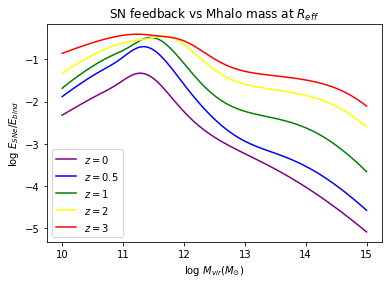

In [23]:
###################SNE feedback################################


z1= 0.
z2= 0.5
z3= 1.
z4= 2.
z5= 3.


Mhalo = np.logspace(10, 15, 100)

SNE_f1=[]
SNE_f2=[]
SNE_f3=[]
SNE_f4=[]
SNE_f5=[]


for i in range(0, 100):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    m_s2 = SHMR(z2,Mhalo[i])
    m_s3 = SHMR(z3,Mhalo[i])
    m_s4 = SHMR(z4,Mhalo[i])
    m_s5 = SHMR(z5,Mhalo[i])
    reff_all1 = avg_rad_eff(m_s1, z1)
    reff_all2 = avg_rad_eff(m_s2, z2)
    reff_all3 = avg_rad_eff(m_s3, z3)
    reff_all4 = avg_rad_eff(m_s4, z4)
    reff_all5 = avg_rad_eff(m_s5, z5)
    SNE_f1.append(SNE_feedback(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    SNE_f2.append(SNE_feedback(m_v, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, z2, z2, h))
    SNE_f3.append(SNE_feedback(m_v, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, z3, z3, h))
    SNE_f4.append(SNE_feedback(m_v, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, z4, z4, h))
    SNE_f5.append(SNE_feedback(m_v, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, z5, z5, h))




plt.title('SN feedback vs Mhalo mass at $R_{eff}$')
plt.plot(np.log10(Mhalo), np.log10(SNE_f1), '-k', color='purple', label='$z=0$')
plt.plot(np.log10(Mhalo), np.log10(SNE_f2), '-k', color='blue', label='$z=0.5$')
plt.plot(np.log10(Mhalo), np.log10(SNE_f3), '-k', color='green', label='$z=1$')
plt.plot(np.log10(Mhalo), np.log10(SNE_f4), '-k', color='yellow', label='$z=2$')
plt.plot(np.log10(Mhalo), np.log10(SNE_f5), '-k', color='red', label='$z=3$')
plt.xlabel('log $M_{vir} (M_{\odot})$')
plt.ylabel('log $E_{SNe}/E_{bind}$')
plt.legend(loc='lower left')
plt.show()

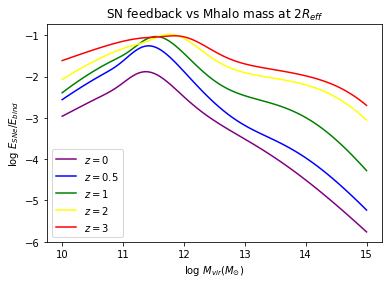

In [24]:
###################SNE feedback################################

z1= 0.
z2= 0.5
z3= 1.
z4= 2.
z5= 3.


Mhalo = np.logspace(10, 15, 100)

SNE_f1=[]
SNE_f2=[]
SNE_f3=[]
SNE_f4=[]
SNE_f5=[]


for i in range(0, 100):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    m_s2 = SHMR(z2,Mhalo[i])
    m_s3 = SHMR(z3,Mhalo[i])
    m_s4 = SHMR(z4,Mhalo[i])
    m_s5 = SHMR(z5,Mhalo[i])
    reff_all1 = 2*avg_rad_eff(m_s1, z1)
    reff_all2 = 2*avg_rad_eff(m_s2, z2)
    reff_all3 = 2*avg_rad_eff(m_s3, z3)
    reff_all4 = 2*avg_rad_eff(m_s4, z4)
    reff_all5 = 2*avg_rad_eff(m_s5, z5)
    SNE_f1.append(SNE_feedback(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    SNE_f2.append(SNE_feedback(m_v, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, z2, z2, h))
    SNE_f3.append(SNE_feedback(m_v, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, z3, z3, h))
    SNE_f4.append(SNE_feedback(m_v, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, z4, z4, h))
    SNE_f5.append(SNE_feedback(m_v, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, z5, z5, h))




plt.title('SN feedback vs Mhalo mass at $2R_{eff}$')
plt.plot(np.log10(Mhalo), np.log10(SNE_f1), '-k', color='purple', label='$z=0$')
plt.plot(np.log10(Mhalo), np.log10(SNE_f2), '-k', color='blue', label='$z=0.5$')
plt.plot(np.log10(Mhalo), np.log10(SNE_f3), '-k', color='green', label='$z=1$')
plt.plot(np.log10(Mhalo), np.log10(SNE_f4), '-k', color='yellow', label='$z=2$')
plt.plot(np.log10(Mhalo), np.log10(SNE_f5), '-k', color='red', label='$z=3$')
plt.xlabel('log $M_{vir} (M_{\odot})$')
plt.ylabel('log $E_{SNe}/E_{bind}$')
plt.legend(loc='lower left')
plt.show()

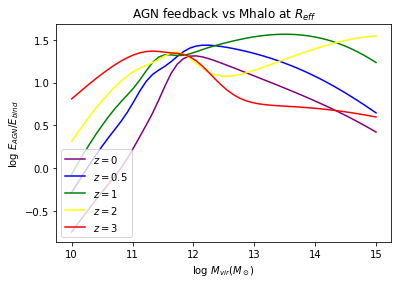

In [25]:
###################AGN feedback################################

z1= 0.
z2= 0.5
z3= 1.
z4= 2.
z5= 3.

Mhalo = np.logspace(10, 15, 50)

AGN_f1 = []
AGN_f2 = []
AGN_f3 = []
AGN_f4 = []
AGN_f5 = []


for i in range(0, 50):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    m_s2 = SHMR(z2,Mhalo[i])
    m_s3 = SHMR(z3,Mhalo[i])
    m_s4 = SHMR(z4,Mhalo[i])
    m_s5 = SHMR(z5,Mhalo[i])
    reff_all1 = avg_rad_eff(m_s1, z1)
    reff_all2 = avg_rad_eff(m_s2, z2)
    reff_all3 = avg_rad_eff(m_s3, z3)
    reff_all4 = avg_rad_eff(m_s4, z4)
    reff_all5 = avg_rad_eff(m_s5, z5)
    AGN_f1.append(AGN_feedback(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    AGN_f2.append(AGN_feedback(m_v, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, z2, z2, h))
    AGN_f3.append(AGN_feedback(m_v, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, z3, z3, h))
    AGN_f4.append(AGN_feedback(m_v, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, z4, z4, h))
    AGN_f5.append(AGN_feedback(m_v, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, z5, z5, h))


plt.title('AGN feedback vs Mhalo at $R_{eff}$ ')
plt.plot(np.log10(Mhalo), np.log10(AGN_f1),'-k',color='purple', label='$z=0$')
plt.plot(np.log10(Mhalo), np.log10(AGN_f2),'-k',color='blue', label='$z=0.5$')
plt.plot(np.log10(Mhalo), np.log10(AGN_f3),'-k',color='green', label='$z=1$')
plt.plot(np.log10(Mhalo), np.log10(AGN_f4),'-k',color='yellow', label='$z=2$')
plt.plot( np.log10(Mhalo), np.log10(AGN_f5),'-k', color='red', label='$z=3$')


plt.xlabel('log $M_{vir}(M_\odot)$')
plt.ylabel('log $E_{AGN}/E_{bind}$')
plt.legend(loc='lower left')
plt.show()

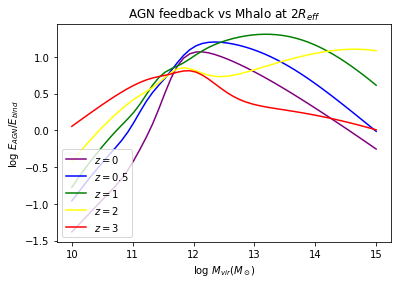

In [26]:
###################AGN feedback################################

z1= 0.
z2= 0.5
z3= 1.
z4= 2.
z5= 3.

Mhalo = np.logspace(10, 15, 50)

AGN_f1 = []
AGN_f2 = []
AGN_f3 = []
AGN_f4 = []
AGN_f5 = []


for i in range(0, 50):
    m_v = Mhalo[i]
    m_s1 = SHMR(z1,Mhalo[i])
    m_s2 = SHMR(z2,Mhalo[i])
    m_s3 = SHMR(z3,Mhalo[i])
    m_s4 = SHMR(z4,Mhalo[i])
    m_s5 = SHMR(z5,Mhalo[i])
    reff_all1 = 2 * avg_rad_eff(m_s1, z1)
    reff_all2 = 2 * avg_rad_eff(m_s2, z2)
    reff_all3 = 2 * avg_rad_eff(m_s3, z3)
    reff_all4 = 2 * avg_rad_eff(m_s4, z4)
    reff_all5 = 2 * avg_rad_eff(m_s5, z5)
    AGN_f1.append(AGN_feedback(m_v, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, z1, z1, h))
    AGN_f2.append(AGN_feedback(m_v, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, z2, z2, h))
    AGN_f3.append(AGN_feedback(m_v, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, z3, z3, h))
    AGN_f4.append(AGN_feedback(m_v, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, z4, z4, h))
    AGN_f5.append(AGN_feedback(m_v, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, z5, z5, h))


plt.title('AGN feedback vs Mhalo at $2R_{eff}$ ')
plt.plot(np.log10(Mhalo), np.log10(AGN_f1),'-k',color='purple', label='$z=0$')
plt.plot(np.log10(Mhalo), np.log10(AGN_f2),'-k',color='blue', label='$z=0.5$')
plt.plot(np.log10(Mhalo), np.log10(AGN_f3),'-k',color='green', label='$z=1$')
plt.plot(np.log10(Mhalo), np.log10(AGN_f4),'-k',color='yellow', label='$z=2$')
plt.plot( np.log10(Mhalo), np.log10(AGN_f5),'-k', color='red', label='$z=3$')


plt.xlabel('log $M_{vir}(M_\odot)$')
plt.ylabel('log $E_{AGN}/E_{bind}$')
plt.legend(loc='lower left')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


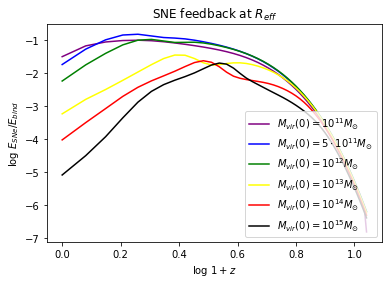

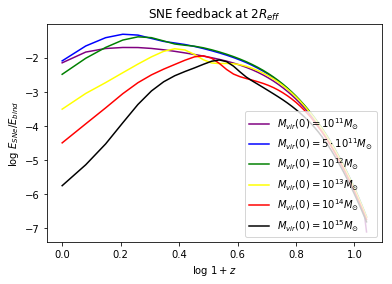

In [27]:
###################SNE feedback################################


z0 = 0
z = np.linspace(0., 10, 50)
Mvir = [1e11,5e11,1e12,1e13,1e14,1e15,]

SNE_f1=[]
SNE_f2=[]
SNE_f3=[]
SNE_f4=[]
SNE_f5=[]
SNE_f6=[]


for i in range(0, 50):
    redshift = z[i]
    m_v1 = halo_mass_assembly(Mvir[0], z0, redshift)
    m_v2 = halo_mass_assembly(Mvir[1], z0, redshift)
    m_v3 = halo_mass_assembly(Mvir[2], z0, redshift)
    m_v4 = halo_mass_assembly(Mvir[3], z0, redshift)
    m_v5 = halo_mass_assembly(Mvir[4], z0, redshift)
    m_v6 = halo_mass_assembly(Mvir[5], z0, redshift)
    m_s1 = SHMR(redshift,m_v1)
    m_s2 = SHMR(redshift,m_v2)
    m_s3 = SHMR(redshift,m_v3)
    m_s4 = SHMR(redshift,m_v4)
    m_s5 = SHMR(redshift,m_v5)
    m_s6 = SHMR(redshift,m_v6)
    reff_all1 = avg_rad_eff(m_s1, redshift)
    reff_all2 = avg_rad_eff(m_s2, redshift)
    reff_all3 = avg_rad_eff(m_s3, redshift)
    reff_all4 = avg_rad_eff(m_s4, redshift)
    reff_all5 = avg_rad_eff(m_s5, redshift)
    reff_all6 = avg_rad_eff(m_s6, redshift)
    SNE_f1.append(SNE_feedback(m_v1, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f2.append(SNE_feedback(m_v2, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f3.append(SNE_feedback(m_v3, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f4.append(SNE_feedback(m_v4, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f5.append(SNE_feedback(m_v5, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f6.append(SNE_feedback(m_v6, m_s6, reff_all6,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))


plt.title('SNE feedback at $R_{eff}$')
plt.plot(np.log10(1+z), np.log10(SNE_f1), '-k', color='purple', label='$M_{vir}(0)=10^{11}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(SNE_f2), '-k', color='blue', label='$M_{vir}(0)=5\cdot10^{11}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(SNE_f3), '-k', color='green', label='$M_{vir}(0)=10^{12}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(SNE_f4), '-k', color='yellow', label='$M_{vir}(0)=10^{13}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(SNE_f5), '-k', color='red', label='$M_{vir}(0)=10^{14}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(SNE_f6), '-k', color='black', label='$M_{vir}(0)=10^{15}M_{\odot}$')
plt.xlabel('log $1+z$')
plt.ylabel('log $E_{SNe}/E_{bind}$')
plt.legend(loc='lower right')
plt.show()




z0 = 0
z = np.linspace(0., 10, 50)
Mvir = [1e11,5e11,1e12,1e13,1e14,1e15,]

SNE_f1=[]
SNE_f2=[]
SNE_f3=[]
SNE_f4=[]
SNE_f5=[]
SNE_f6=[]


for i in range(0, 50):
    redshift = z[i]
    m_v1 = halo_mass_assembly(Mvir[0], z0, redshift)
    m_v2 = halo_mass_assembly(Mvir[1], z0, redshift)
    m_v3 = halo_mass_assembly(Mvir[2], z0, redshift)
    m_v4 = halo_mass_assembly(Mvir[3], z0, redshift)
    m_v5 = halo_mass_assembly(Mvir[4], z0, redshift)
    m_v6 = halo_mass_assembly(Mvir[5], z0, redshift)
    m_s1 = SHMR(redshift,m_v1)
    m_s2 = SHMR(redshift,m_v2)
    m_s3 = SHMR(redshift,m_v3)
    m_s4 = SHMR(redshift,m_v4)
    m_s5 = SHMR(redshift,m_v5)
    m_s6 = SHMR(redshift,m_v6)
    reff_all1 = 2*avg_rad_eff(m_s1, redshift)
    reff_all2 = 2*avg_rad_eff(m_s2, redshift)
    reff_all3 = 2*avg_rad_eff(m_s3, redshift)
    reff_all4 = 2*avg_rad_eff(m_s4, redshift)
    reff_all5 = 2*avg_rad_eff(m_s5, redshift)
    reff_all6 = 2*avg_rad_eff(m_s6, redshift)
    SNE_f1.append(SNE_feedback(m_v1, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f2.append(SNE_feedback(m_v2, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f3.append(SNE_feedback(m_v3, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f4.append(SNE_feedback(m_v4, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f5.append(SNE_feedback(m_v5, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    SNE_f6.append(SNE_feedback(m_v6, m_s6, reff_all6,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))


plt.title('SNE feedback at $2R_{eff}$')
plt.plot(np.log10(1+z), np.log10(SNE_f1), '-k', color='purple', label='$M_{vir}(0)=10^{11}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(SNE_f2), '-k', color='blue', label='$M_{vir}(0)=5\cdot10^{11}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(SNE_f3), '-k', color='green', label='$M_{vir}(0)=10^{12}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(SNE_f4), '-k', color='yellow', label='$M_{vir}(0)=10^{13}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(SNE_f5), '-k', color='red', label='$M_{vir}(0)=10^{14}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(SNE_f6), '-k', color='black', label='$M_{vir}(0)=10^{15}M_{\odot}$')
plt.xlabel('log $1+z$')
plt.ylabel('log $E_{SNe}/E_{bind}$')
plt.legend(loc='lower right')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


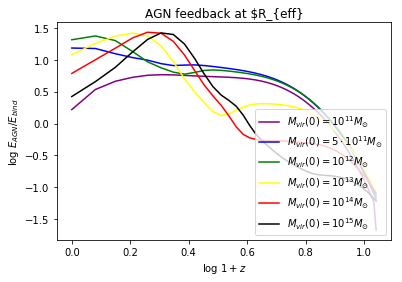

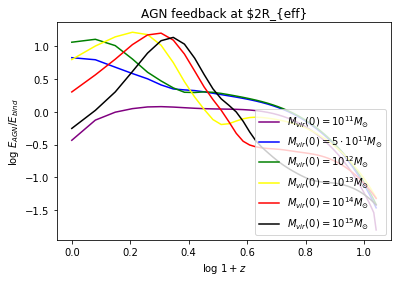

In [28]:
###################AGN feedback################################


z0 = 0
z = np.linspace(0., 10, 50)
Mvir = [1e11,5e11,1e12,1e13,1e14,1e15,]

AGN_f1=[]
AGN_f2=[]
AGN_f3=[]
AGN_f4=[]
AGN_f5=[]
AGN_f6=[]


for i in range(0, 50):
    redshift = z[i]
    m_v1 = halo_mass_assembly(Mvir[0], z0, redshift)
    m_v2 = halo_mass_assembly(Mvir[1], z0, redshift)
    m_v3 = halo_mass_assembly(Mvir[2], z0, redshift)
    m_v4 = halo_mass_assembly(Mvir[3], z0, redshift)
    m_v5 = halo_mass_assembly(Mvir[4], z0, redshift)
    m_v6 = halo_mass_assembly(Mvir[5], z0, redshift)
    m_s1 = SHMR(redshift,m_v1)
    m_s2 = SHMR(redshift,m_v2)
    m_s3 = SHMR(redshift,m_v3)
    m_s4 = SHMR(redshift,m_v4)
    m_s5 = SHMR(redshift,m_v5)
    m_s6 = SHMR(redshift,m_v6)
    reff_all1 = avg_rad_eff(m_s1, redshift)
    reff_all2 = avg_rad_eff(m_s2, redshift)
    reff_all3 = avg_rad_eff(m_s3, redshift)
    reff_all4 = avg_rad_eff(m_s4, redshift)
    reff_all5 = avg_rad_eff(m_s5, redshift)
    reff_all6 = avg_rad_eff(m_s6, redshift)
    AGN_f1.append(AGN_feedback(m_v1, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f2.append(AGN_feedback(m_v2, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f3.append(AGN_feedback(m_v3, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f4.append(AGN_feedback(m_v4, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f5.append(AGN_feedback(m_v5, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f6.append(AGN_feedback(m_v6, m_s6, reff_all6,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))



plt.title('AGN feedback at $R_{eff}')
plt.plot(np.log10(1+z), np.log10(AGN_f1), '-k', color='purple', label='$M_{vir}(0)=10^{11}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(AGN_f2), '-k', color='blue', label='$M_{vir}(0)=5\cdot10^{11}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(AGN_f3), '-k', color='green', label='$M_{vir}(0)=10^{12}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(AGN_f4), '-k', color='yellow', label='$M_{vir}(0)=10^{13}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(AGN_f5), '-k', color='red', label='$M_{vir}(0)=10^{14}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(AGN_f6), '-k', color='black', label='$M_{vir}(0)=10^{15}M_{\odot}$')
plt.xlabel('log $1+z$')
plt.ylabel('log $E_{AGN}/E_{bind}$')
plt.legend(loc='lower right')
plt.show()



z0 = 0
z = np.linspace(0., 10, 50)
Mvir = [1e11,5e11,1e12,1e13,1e14,1e15,]

AGN_f1=[]
AGN_f2=[]
AGN_f3=[]
AGN_f4=[]
AGN_f5=[]
AGN_f6=[]


for i in range(0, 50):
    redshift = z[i]
    m_v1 = halo_mass_assembly(Mvir[0], z0, redshift)
    m_v2 = halo_mass_assembly(Mvir[1], z0, redshift)
    m_v3 = halo_mass_assembly(Mvir[2], z0, redshift)
    m_v4 = halo_mass_assembly(Mvir[3], z0, redshift)
    m_v5 = halo_mass_assembly(Mvir[4], z0, redshift)
    m_v6 = halo_mass_assembly(Mvir[5], z0, redshift)
    m_s1 = SHMR(redshift,m_v1)
    m_s2 = SHMR(redshift,m_v2)
    m_s3 = SHMR(redshift,m_v3)
    m_s4 = SHMR(redshift,m_v4)
    m_s5 = SHMR(redshift,m_v5)
    m_s6 = SHMR(redshift,m_v6)
    reff_all1 = 2*avg_rad_eff(m_s1, redshift)
    reff_all2 = 2*avg_rad_eff(m_s2, redshift)
    reff_all3 = 2*avg_rad_eff(m_s3, redshift)
    reff_all4 = 2*avg_rad_eff(m_s4, redshift)
    reff_all5 = 2*avg_rad_eff(m_s5, redshift)
    reff_all6 = 2*avg_rad_eff(m_s6, redshift)
    AGN_f1.append(AGN_feedback(m_v1, m_s1, reff_all1,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f2.append(AGN_feedback(m_v2, m_s2, reff_all2,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f3.append(AGN_feedback(m_v3, m_s3, reff_all3,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f4.append(AGN_feedback(m_v4, m_s4, reff_all4,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f5.append(AGN_feedback(m_v5, m_s5, reff_all5,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))
    AGN_f6.append(AGN_feedback(m_v6, m_s6, reff_all6,  Om_mat_cero, Om_lambda_cero, redshift, z0, h))



plt.title('AGN feedback at $2R_{eff}')
plt.plot(np.log10(1+z), np.log10(AGN_f1), '-k', color='purple', label='$M_{vir}(0)=10^{11}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(AGN_f2), '-k', color='blue', label='$M_{vir}(0)=5\cdot10^{11}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(AGN_f3), '-k', color='green', label='$M_{vir}(0)=10^{12}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(AGN_f4), '-k', color='yellow', label='$M_{vir}(0)=10^{13}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(AGN_f5), '-k', color='red', label='$M_{vir}(0)=10^{14}M_{\odot}$')
plt.plot(np.log10(1+z), np.log10(AGN_f6), '-k', color='black', label='$M_{vir}(0)=10^{15}M_{\odot}$')
plt.xlabel('log $1+z$')
plt.ylabel('log $E_{AGN}/E_{bind}$')
plt.legend(loc='lower right')
plt.show()

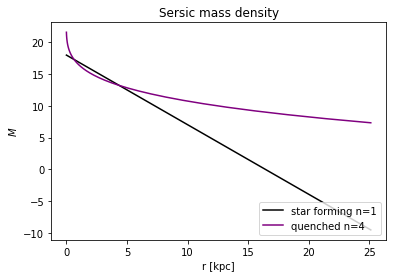

In [16]:
Sersic_sf_mass_density(Ms, z, r)
Sersic_q_mass_density(Ms, z, r)

z= 0.
Mvir = (1e11,1e12,1e13,1e14,1e15)
Ms = SHMR(z,Mvir[0])

m_n1 = []

m_n4 = []

radius = np.logspace(-2, 1.4, 50)
for i in range(0, 50):
    r = radius[i]
    m_n1.append(Sersic_sf_mass_density(Ms, z, r))
    m_n4.append(Sersic_q_mass_density(Ms, z, r))
    
plt.title('Sersic mass density')
plt.plot(radius, np.log(m_n1), '-k', color='black', label='star forming n=1')
plt.plot(radius, np.log(m_n4), '-k', color='purple', label='quenched n=4')

plt.savefig('/Users/ximena/Desktop/sersic_mass.pdf',format='pdf',dpi=200, bbox_inches = 'tight')

plt.xlabel('r [kpc]')
plt.ylabel('$M$')
plt.legend(loc='lower right')
plt.savefig('/Users/ximena/Desktop/sersic_mass.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()